# Final Experiment (Pain Level Classification)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.utils import compute_class_weight
from sklearn.metrics import roc_curve, precision_recall_curve, PrecisionRecallDisplay, balanced_accuracy_score
from tensorflow.keras.models import load_model
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset, get_class_names
from src.lib.time_series_augmentation.utils.augmentation import jitter, rotation
from src.models.CNNLSTM import CNNLSTM
from src.models.RCNN import RCNN
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
kf = KFold(n_splits=10, shuffle=True, random_state=48)
epochs = 100
cnn_auc = []
rnn_auc = []

In [3]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body (Skeleton Pose Estimation)

In [7]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', level=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(783, 1, 350, 35) (783, 4)
(274, 1, 350, 35) (274, 4)


In [9]:
classes = get_class_names('skeleton', level=True)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain     403
Mild        219
Moderate    158
Severe        3
dtype: int64

In [10]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.8938356164383562, 1: 1.2389240506329113, 2: 0.4857320099255583, 3: 65.25}

### 1.1 CNN + BiLSTM

Epoch 1/100
22/22 - 5s - loss: 2.2064 - accuracy: 0.4006 - auc_1: 0.6911 - precision_1: 0.4586 - recall_1: 0.1179 - f1_score: 0.2845 - val_loss: 1.2508 - val_accuracy: 0.3291 - val_auc_1: 0.6550 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1539 - 5s/epoch - 221ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3319 - accuracy: 0.4688 - auc_1: 0.7643 - precision_1: 0.6069 - recall_1: 0.1491 - f1_score: 0.3498 - val_loss: 1.2514 - val_accuracy: 0.4937 - val_auc_1: 0.7302 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2549 - 987ms/epoch - 45ms/step
Epoch 3/100
22/22 - 1s - loss: 1.0521 - accuracy: 0.4957 - auc_1: 0.7658 - precision_1: 0.5703 - recall_1: 0.2131 - f1_score: 0.3835 - val_loss: 1.1375 - val_accuracy: 0.5063 - val_auc_1: 0.7541 - val_precision_1: 0.5507 - val_recall_1: 0.4810 - val_f1_score: 0.1979 - 1s/epoch - 54ms/step
Epoch 4/100
22/22 - 1s - loss: 0.9141 - accuracy: 0.5327 - auc_1: 0.8057 - precision_1: 0.6076 - recall_1: 0.3

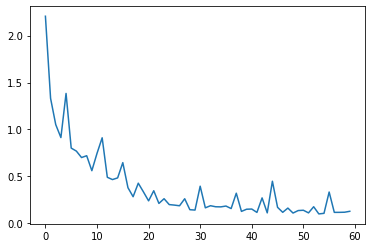

Epoch 1/100
22/22 - 5s - loss: 2.4751 - accuracy: 0.3849 - auc_2: 0.6904 - precision_2: 0.3774 - recall_2: 0.0852 - f1_score: 0.2734 - val_loss: 1.3074 - val_accuracy: 0.1772 - val_auc_2: 0.5892 - val_precision_2: 0.3333 - val_recall_2: 0.0127 - val_f1_score: 0.0753 - 5s/epoch - 215ms/step
Epoch 2/100
22/22 - 1s - loss: 1.4608 - accuracy: 0.4105 - auc_2: 0.7168 - precision_2: 0.5037 - recall_2: 0.0966 - f1_score: 0.3102 - val_loss: 1.2119 - val_accuracy: 0.3797 - val_auc_2: 0.7149 - val_precision_2: 0.3600 - val_recall_2: 0.1139 - val_f1_score: 0.1752 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 1.3718 - accuracy: 0.4361 - auc_2: 0.6983 - precision_2: 0.4183 - recall_2: 0.0909 - f1_score: 0.3312 - val_loss: 1.2968 - val_accuracy: 0.3165 - val_auc_2: 0.6400 - val_precision_2: 0.3714 - val_recall_2: 0.1646 - val_f1_score: 0.1214 - 983ms/epoch - 45ms/step
Epoch 4/100
22/22 - 1s - loss: 1.1321 - accuracy: 0.4588 - auc_2: 0.7402 - precision_2: 0.5225 - recall_2: 0.1648 - f1_score: 

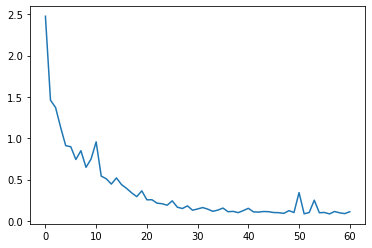

Epoch 1/100


In [12]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_intensity_body_model = CNNLSTM(n_features, None, n_length, n_outputs, multiclass=True)
    history = cnnlstm_intensity_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_intensity_body_model.save(model_path / 'body_intensity_cnnlstm.h5')

#### Training performance

In [8]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.9281993448734284,
 'ROC/AUC': 0.9951982140541077,
 'Precision': 0.9316250622272492,
 'Recall': 0.9247938930988312,
 'F1-score': 0.8373075246810913}

#### Validation performance

In [9]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.5326192885637283,
 'ROC/AUC': 0.8024416506290436,
 'Precision': 0.5489367544651031,
 'Recall': 0.5224115669727325,
 'F1-score': 0.3036697179079056}

#### Predictions and performance on test set

In [10]:
cnnlstm_intensity_body_model = load_model(model_path / 'body_intensity_cnnlstm.h5')
y_pred = cnnlstm_intensity_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_intensity_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 15ms/step - loss: 2.2712 - accuracy: 0.2409 - auc_9: 0.6009 - precision_9: 0.2524 - recall_9: 0.1898 - f1_score: 0.1674
Accuracy: 24.09% 
Balanced Accuracy: 25.55% 
ROC/AUC: 0.60 
Precision: 0.25 
Recall: 0.19 
F1 score: 0.17


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

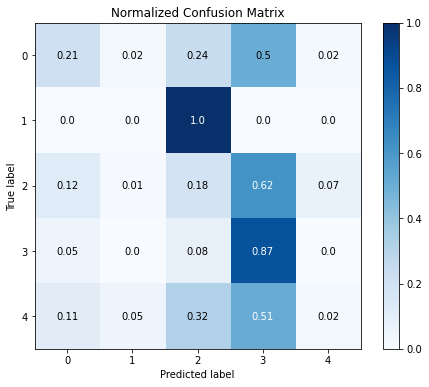

In [11]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

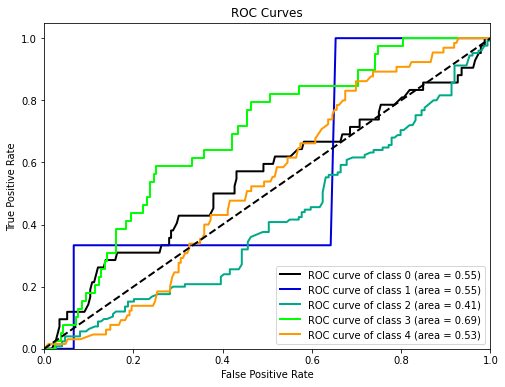

In [12]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

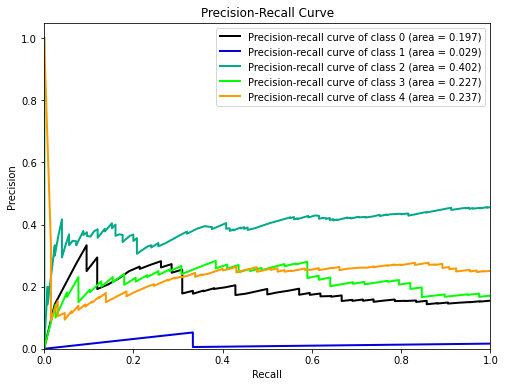

In [17]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, plot_micro=False, figsize=(8,6))

### 1.2 RCNN

In [18]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_intensity_body_model = RCNN(n_features, None, n_length, n_outputs, multiclass=True)
    history = rcnn_intensity_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_intensity_body_model.save(model_path / 'body_intensity_rcnn.h5')

TypeError: __init__() got an unexpected keyword argument 'multiclass'

#### Training performance

In [ ]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.9909151494503021,
 'ROC/AUC': 0.9991476118564606,
 'Precision': 0.9906426191329956,
 'Recall': 0.9905905783176422,
 'F1-score': 0.653450357913971}

#### Validation performance

In [ ]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.6756572604179383,
 'ROC/AUC': 0.730562436580658,
 'Precision': 0.6668010592460633,
 'Recall': 0.6684430181980133,
 'F1-score': 0.6509092807769775}

#### Predictions and performance on test set

In [ ]:
rcnn_intensity_body_model = load_model(model_path / 'body_intensity_rcnn.h5')
y_pred = rcnn_intensity_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_intensity_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 0s 8ms/step - loss: 1.0683 - accuracy: 0.4964 - auc_6: 0.6697 - precision_6: 0.9450 - recall_6: 0.4383 - f1_score: 0.9234
Accuracy: 49.64% 
ROC/AUC: 0.67 
Precision: 0.94 
Recall: 0.44 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

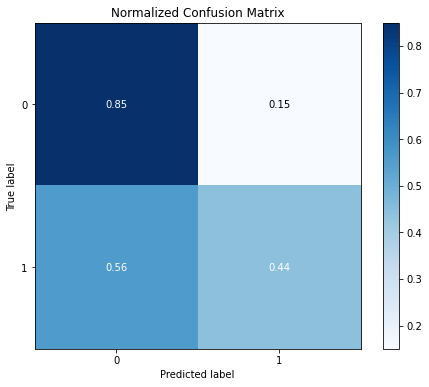

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

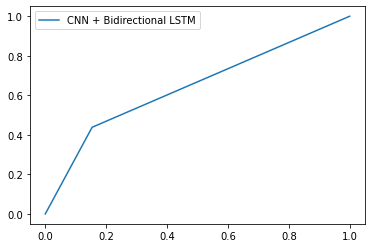

In [ ]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

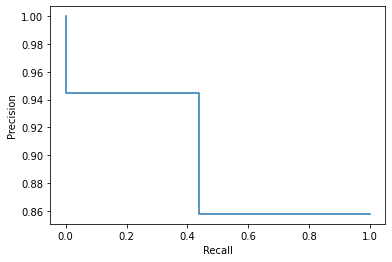

In [ ]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

## 2. Unimodal Face (Facial Expression + Head Pose)

In [ ]:
X_train, X_test, y_train, y_test = load_dataset('AUs', level=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 25) (752, 1)
(268, 1, 350, 25) (268, 1)


In [ ]:
classes = get_class_names('AUs', level=True)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

In [ ]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

### 2.1 CNN + BiLSTM

Epoch 1/100
22/22 - 9s - loss: 0.7339 - accuracy: 0.5651 - auc: 0.5882 - precision: 0.5480 - recall: 0.5446 - f1_score: 0.6494 - val_loss: 0.6932 - val_accuracy: 0.5526 - val_auc: 0.6672 - val_precision: 0.6667 - val_recall: 0.3415 - val_f1_score: 0.7009 - 9s/epoch - 398ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6424 - accuracy: 0.6435 - auc: 0.6892 - precision: 0.6373 - recall: 0.6000 - f1_score: 0.6494 - val_loss: 0.6520 - val_accuracy: 0.6579 - val_auc: 0.6780 - val_precision: 0.6531 - val_recall: 0.7805 - val_f1_score: 0.7009 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6128 - accuracy: 0.6672 - auc: 0.7272 - precision: 0.6678 - recall: 0.6123 - f1_score: 0.6494 - val_loss: 0.6917 - val_accuracy: 0.5658 - val_auc: 0.7192 - val_precision: 0.5541 - val_recall: 1.0000 - val_f1_score: 0.7009 - 948ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5916 - accuracy: 0.6997 - auc: 0.7512 - precision: 0.6805 - recall: 0.7077 - f1_score: 0.6494 - val_loss: 0.6516 - val_accuracy: 

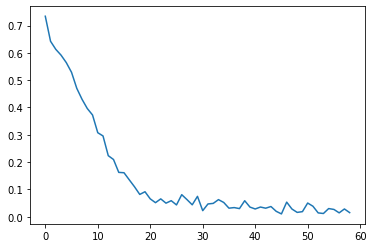

Epoch 1/100
22/22 - 5s - loss: 0.7390 - accuracy: 0.5814 - auc_1: 0.6003 - precision_1: 0.5769 - recall_1: 0.4644 - f1_score: 0.6466 - val_loss: 0.8099 - val_accuracy: 0.4342 - val_auc_1: 0.7847 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.7227 - 5s/epoch - 236ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6338 - accuracy: 0.6524 - auc_1: 0.6970 - precision_1: 0.6583 - recall_1: 0.5666 - f1_score: 0.6466 - val_loss: 0.6308 - val_accuracy: 0.6711 - val_auc_1: 0.7696 - val_precision_1: 0.7647 - val_recall_1: 0.6047 - val_f1_score: 0.7227 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6117 - accuracy: 0.6864 - auc_1: 0.7276 - precision_1: 0.6844 - recall_1: 0.6378 - f1_score: 0.6466 - val_loss: 0.7284 - val_accuracy: 0.5526 - val_auc_1: 0.7664 - val_precision_1: 0.8000 - val_recall_1: 0.2791 - val_f1_score: 0.7227 - 979ms/epoch - 45ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5807 - accuracy: 0.6790 - auc_1: 0.7615 - precision_1: 0.6779 - recall_1: 0.6254 - f1

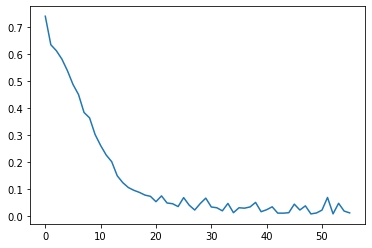

Epoch 1/100
22/22 - 5s - loss: 0.7446 - accuracy: 0.6041 - auc_2: 0.6075 - precision_2: 0.6039 - recall_2: 0.5602 - f1_score: 0.6581 - val_loss: 0.6645 - val_accuracy: 0.6267 - val_auc_2: 0.6557 - val_precision_2: 0.6364 - val_recall_2: 0.4118 - val_f1_score: 0.6239 - 5s/epoch - 232ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6425 - accuracy: 0.6470 - auc_2: 0.6818 - precision_2: 0.6609 - recall_2: 0.5753 - f1_score: 0.6581 - val_loss: 0.6879 - val_accuracy: 0.5467 - val_auc_2: 0.7080 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.6239 - 956ms/epoch - 43ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6138 - accuracy: 0.6617 - auc_2: 0.7218 - precision_2: 0.6700 - recall_2: 0.6114 - f1_score: 0.6581 - val_loss: 0.7194 - val_accuracy: 0.5467 - val_auc_2: 0.6435 - val_precision_2: 0.5000 - val_recall_2: 0.4412 - val_f1_score: 0.6239 - 972ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5830 - accuracy: 0.6780 - auc_2: 0.7612 - precision_2: 0.6900 - recall_2: 0.6235 -

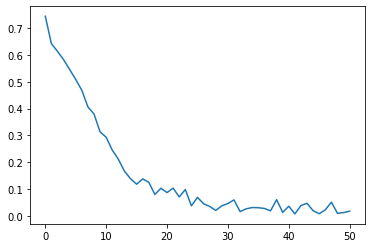

Epoch 1/100
22/22 - 5s - loss: 0.7238 - accuracy: 0.5820 - auc_3: 0.6154 - precision_3: 0.5710 - recall_3: 0.5518 - f1_score: 0.6527 - val_loss: 0.7237 - val_accuracy: 0.5067 - val_auc_3: 0.6575 - val_precision_3: 0.5556 - val_recall_3: 0.1316 - val_f1_score: 0.6726 - 5s/epoch - 245ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6385 - accuracy: 0.6204 - auc_3: 0.6829 - precision_3: 0.6060 - recall_3: 0.6189 - f1_score: 0.6527 - val_loss: 0.7151 - val_accuracy: 0.4933 - val_auc_3: 0.6782 - val_precision_3: 0.5000 - val_recall_3: 0.0263 - val_f1_score: 0.6726 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6270 - accuracy: 0.6322 - auc_3: 0.7055 - precision_3: 0.6215 - recall_3: 0.6159 - f1_score: 0.6527 - val_loss: 0.7003 - val_accuracy: 0.5733 - val_auc_3: 0.6671 - val_precision_3: 0.8000 - val_recall_3: 0.2105 - val_f1_score: 0.6726 - 1s/epoch - 53ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5852 - accuracy: 0.7001 - auc_3: 0.7552 - precision_3: 0.7010 - recall_3: 0.6646 - f1_score: 0.6

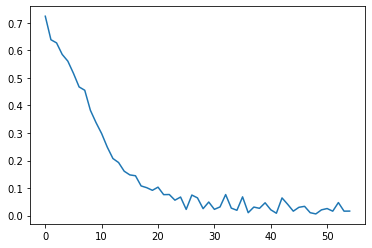

Epoch 1/100
22/22 - 5s - loss: 0.7724 - accuracy: 0.5923 - auc_4: 0.6060 - precision_4: 0.5912 - recall_4: 0.5629 - f1_score: 0.6607 - val_loss: 0.7442 - val_accuracy: 0.4133 - val_auc_4: 0.4982 - val_precision_4: 0.4000 - val_recall_4: 0.7500 - val_f1_score: 0.5981 - 5s/epoch - 241ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6417 - accuracy: 0.6366 - auc_4: 0.6842 - precision_4: 0.6350 - recall_4: 0.6198 - f1_score: 0.6607 - val_loss: 0.8086 - val_accuracy: 0.4133 - val_auc_4: 0.5476 - val_precision_4: 0.4091 - val_recall_4: 0.8438 - val_f1_score: 0.5981 - 988ms/epoch - 45ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6065 - accuracy: 0.6765 - auc_4: 0.7319 - precision_4: 0.6667 - recall_4: 0.6886 - f1_score: 0.6607 - val_loss: 0.8635 - val_accuracy: 0.5733 - val_auc_4: 0.6948 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.5981 - 977ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5719 - accuracy: 0.7223 - auc_4: 0.7740 - precision_4: 0.7310 - recall_4: 0.6916 -

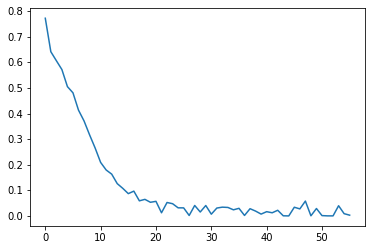

Epoch 1/100
22/22 - 5s - loss: 0.7398 - accuracy: 0.5953 - auc_5: 0.6067 - precision_5: 0.5972 - recall_5: 0.5137 - f1_score: 0.6541 - val_loss: 0.7382 - val_accuracy: 0.4933 - val_auc_5: 0.5082 - val_precision_5: 0.4933 - val_recall_5: 1.0000 - val_f1_score: 0.6607 - 5s/epoch - 234ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6496 - accuracy: 0.6455 - auc_5: 0.6751 - precision_5: 0.6297 - recall_5: 0.6565 - f1_score: 0.6541 - val_loss: 0.6132 - val_accuracy: 0.6800 - val_auc_5: 0.7592 - val_precision_5: 0.6512 - val_recall_5: 0.7568 - val_f1_score: 0.6607 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6076 - accuracy: 0.6558 - auc_5: 0.7281 - precision_5: 0.6429 - recall_5: 0.6565 - f1_score: 0.6541 - val_loss: 0.8122 - val_accuracy: 0.5600 - val_auc_5: 0.7351 - val_precision_5: 0.8333 - val_recall_5: 0.1351 - val_f1_score: 0.6607 - 914ms/epoch - 42ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5827 - accuracy: 0.6957 - auc_5: 0.7628 - precision_5: 0.6965 - recall_5: 0.6626 - f1_score: 

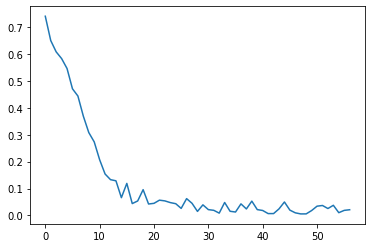

Epoch 1/100
22/22 - 5s - loss: 0.7013 - accuracy: 0.5805 - auc_6: 0.6042 - precision_6: 0.5839 - recall_6: 0.5030 - f1_score: 0.6581 - val_loss: 0.7239 - val_accuracy: 0.4533 - val_auc_6: 0.7145 - val_precision_6: 0.4533 - val_recall_6: 1.0000 - val_f1_score: 0.6239 - 5s/epoch - 233ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6355 - accuracy: 0.6662 - auc_6: 0.6953 - precision_6: 0.6743 - recall_6: 0.6175 - f1_score: 0.6581 - val_loss: 0.6438 - val_accuracy: 0.5733 - val_auc_6: 0.7364 - val_precision_6: 0.6000 - val_recall_6: 0.1765 - val_f1_score: 0.6239 - 1s/epoch - 55ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6232 - accuracy: 0.6647 - auc_6: 0.7111 - precision_6: 0.6895 - recall_6: 0.5753 - f1_score: 0.6581 - val_loss: 0.6302 - val_accuracy: 0.6800 - val_auc_6: 0.7242 - val_precision_6: 0.6190 - val_recall_6: 0.7647 - val_f1_score: 0.6239 - 1s/epoch - 54ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6039 - accuracy: 0.6647 - auc_6: 0.7344 - precision_6: 0.6688 - recall_6: 0.6265 - f1_score: 0.6

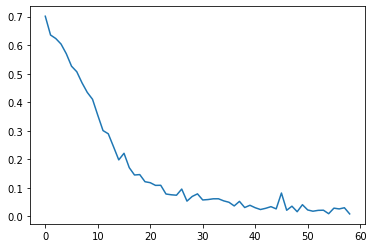

Epoch 1/100
22/22 - 5s - loss: 0.7444 - accuracy: 0.5835 - auc_7: 0.6131 - precision_7: 0.5825 - recall_7: 0.5227 - f1_score: 0.6567 - val_loss: 0.6862 - val_accuracy: 0.5200 - val_auc_7: 0.6014 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.6364 - 5s/epoch - 230ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6258 - accuracy: 0.6455 - auc_7: 0.7055 - precision_7: 0.6553 - recall_7: 0.5801 - f1_score: 0.6567 - val_loss: 0.6824 - val_accuracy: 0.6933 - val_auc_7: 0.6604 - val_precision_7: 0.6579 - val_recall_7: 0.7143 - val_f1_score: 0.6364 - 1s/epoch - 55ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5948 - accuracy: 0.6839 - auc_7: 0.7497 - precision_7: 0.6944 - recall_7: 0.6314 - f1_score: 0.6567 - val_loss: 0.7203 - val_accuracy: 0.5600 - val_auc_7: 0.5807 - val_precision_7: 0.5250 - val_recall_7: 0.6000 - val_f1_score: 0.6364 - 941ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5629 - accuracy: 0.7164 - auc_7: 0.7850 - precision_7: 0.7100 - recall_7: 0.7100 - f1

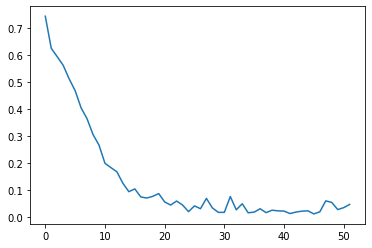

Epoch 1/100
22/22 - 5s - loss: 0.7573 - accuracy: 0.5923 - auc_8: 0.5939 - precision_8: 0.5814 - recall_8: 0.5385 - f1_score: 0.6487 - val_loss: 0.7248 - val_accuracy: 0.5467 - val_auc_8: 0.5348 - val_precision_8: 0.5467 - val_recall_8: 1.0000 - val_f1_score: 0.7069 - 5s/epoch - 241ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6415 - accuracy: 0.6499 - auc_8: 0.6930 - precision_8: 0.6392 - recall_8: 0.6215 - f1_score: 0.6487 - val_loss: 0.8384 - val_accuracy: 0.4533 - val_auc_8: 0.5395 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.7069 - 998ms/epoch - 45ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6035 - accuracy: 0.6691 - auc_8: 0.7354 - precision_8: 0.6689 - recall_8: 0.6154 - f1_score: 0.6487 - val_loss: 0.6903 - val_accuracy: 0.6133 - val_auc_8: 0.6277 - val_precision_8: 0.6579 - val_recall_8: 0.6098 - val_f1_score: 0.7069 - 1s/epoch - 58ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5888 - accuracy: 0.6854 - auc_8: 0.7554 - precision_8: 0.6806 - recall_8: 0.6492 - f1

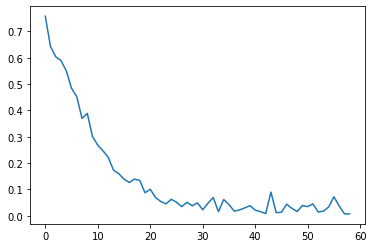

Epoch 1/100
22/22 - 5s - loss: 0.7241 - accuracy: 0.6027 - auc_9: 0.6288 - precision_9: 0.6019 - recall_9: 0.5821 - f1_score: 0.6621 - val_loss: 0.6457 - val_accuracy: 0.6400 - val_auc_9: 0.6763 - val_precision_9: 0.5769 - val_recall_9: 0.4839 - val_f1_score: 0.5849 - 5s/epoch - 243ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6266 - accuracy: 0.6425 - auc_9: 0.7007 - precision_9: 0.6655 - recall_9: 0.5582 - f1_score: 0.6621 - val_loss: 0.6821 - val_accuracy: 0.5867 - val_auc_9: 0.4710 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.5849 - 986ms/epoch - 45ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6138 - accuracy: 0.6470 - auc_9: 0.7187 - precision_9: 0.6600 - recall_9: 0.5910 - f1_score: 0.6621 - val_loss: 0.7213 - val_accuracy: 0.4400 - val_auc_9: 0.6107 - val_precision_9: 0.4035 - val_recall_9: 0.7419 - val_f1_score: 0.5849 - 965ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5655 - accuracy: 0.6765 - auc_9: 0.7728 - precision_9: 0.6779 - recall_9: 0.6597 -

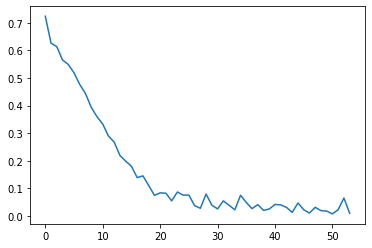

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_face_model = CNNLSTM(n_features, None, n_length, n_outputs)
    history = cnnlstm_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_face_model.save(model_path / 'face_binary_cnnlstm.h5')

#### Training performance

In [ ]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.9942377626895904,
 'ROC/AUC': 0.9997448980808258,
 'Precision': 0.9933254599571228,
 'Recall': 0.9948463082313538,
 'F1-score': 0.6547199666500092}

#### Validation performance

In [ ]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.6369473814964295,
 'ROC/AUC': 0.6908802628517151,
 'Precision': 0.6173736810684204,
 'Recall': 0.6787478744983673,
 'F1-score': 0.6530827581882477}

#### Predictions and performance on test set

In [ ]:
cnnlstm_binary_face_model = load_model(model_path / 'face_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 16ms/step - loss: 0.9153 - accuracy: 0.5037 - auc_8: 0.5672 - precision_8: 0.8889 - recall_8: 0.4848 - f1_score: 0.9259
Accuracy: 50.37% 
ROC/AUC: 0.57 
Precision: 0.89 
Recall: 0.48 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

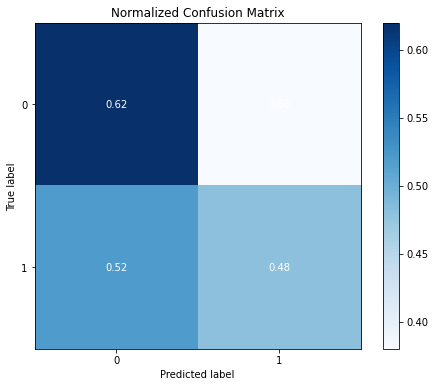

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

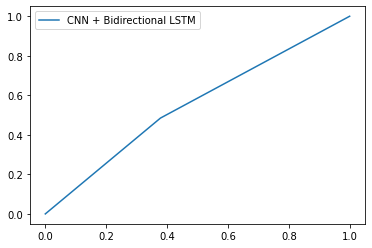

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

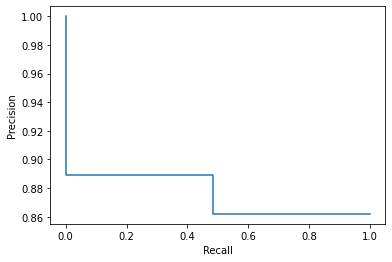

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 2.2 RCNN

Epoch 1/100
22/22 - 5s - loss: 0.7942 - accuracy: 0.5651 - auc_10: 0.5853 - precision_10: 0.5585 - recall_10: 0.4554 - f1_score: 0.6494 - val_loss: 0.7223 - val_accuracy: 0.5395 - val_auc_10: 0.6822 - val_precision_10: 0.5395 - val_recall_10: 1.0000 - val_f1_score: 0.7009 - 5s/epoch - 233ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6367 - accuracy: 0.6524 - auc_10: 0.6957 - precision_10: 0.6389 - recall_10: 0.6369 - f1_score: 0.6494 - val_loss: 0.7140 - val_accuracy: 0.5658 - val_auc_10: 0.6889 - val_precision_10: 0.7500 - val_recall_10: 0.2927 - val_f1_score: 0.7009 - 1s/epoch - 50ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6381 - accuracy: 0.6464 - auc_10: 0.6835 - precision_10: 0.6525 - recall_10: 0.5662 - f1_score: 0.6494 - val_loss: 0.7030 - val_accuracy: 0.5526 - val_auc_10: 0.6122 - val_precision_10: 0.7692 - val_recall_10: 0.2439 - val_f1_score: 0.7009 - 1s/epoch - 55ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5843 - accuracy: 0.6923 - auc_10: 0.7585 - precision_10: 0.6970 - recall_10: 0

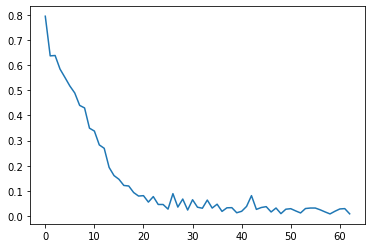

Epoch 1/100
22/22 - 5s - loss: 0.7568 - accuracy: 0.5592 - auc_11: 0.5626 - precision_11: 0.5424 - recall_11: 0.4954 - f1_score: 0.6466 - val_loss: 0.6378 - val_accuracy: 0.6974 - val_auc_11: 0.7287 - val_precision_11: 0.7632 - val_recall_11: 0.6744 - val_f1_score: 0.7227 - 5s/epoch - 235ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6498 - accuracy: 0.6317 - auc_11: 0.6727 - precision_11: 0.6201 - recall_11: 0.5913 - f1_score: 0.6466 - val_loss: 0.5960 - val_accuracy: 0.7237 - val_auc_11: 0.7826 - val_precision_11: 0.7619 - val_recall_11: 0.7442 - val_f1_score: 0.7227 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6194 - accuracy: 0.6553 - auc_11: 0.7156 - precision_11: 0.6406 - recall_11: 0.6347 - f1_score: 0.6466 - val_loss: 0.7832 - val_accuracy: 0.5395 - val_auc_11: 0.4612 - val_precision_11: 0.5541 - val_recall_11: 0.9535 - val_f1_score: 0.7227 - 974ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5817 - accuracy: 0.6908 - auc_11: 0.7617 - precision_11: 0.6696 - recall_11

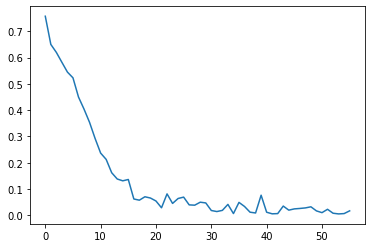

Epoch 1/100
22/22 - 5s - loss: 0.7122 - accuracy: 0.5805 - auc_12: 0.6139 - precision_12: 0.5759 - recall_12: 0.5482 - f1_score: 0.6581 - val_loss: 0.7171 - val_accuracy: 0.4533 - val_auc_12: 0.6137 - val_precision_12: 0.4533 - val_recall_12: 1.0000 - val_f1_score: 0.6239 - 5s/epoch - 236ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6361 - accuracy: 0.6440 - auc_12: 0.6900 - precision_12: 0.6426 - recall_12: 0.6175 - f1_score: 0.6581 - val_loss: 0.7537 - val_accuracy: 0.4533 - val_auc_12: 0.6090 - val_precision_12: 0.4521 - val_recall_12: 0.9706 - val_f1_score: 0.6239 - 925ms/epoch - 42ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6275 - accuracy: 0.6514 - auc_12: 0.7051 - precision_12: 0.6455 - recall_12: 0.6416 - f1_score: 0.6581 - val_loss: 0.6611 - val_accuracy: 0.5867 - val_auc_12: 0.6714 - val_precision_12: 0.5517 - val_recall_12: 0.4706 - val_f1_score: 0.6239 - 1s/epoch - 53ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5830 - accuracy: 0.6942 - auc_12: 0.7547 - precision_12: 0.6801 - recall_12

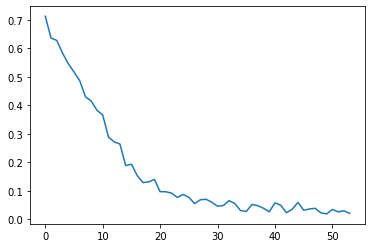

Epoch 1/100
22/22 - 5s - loss: 0.7321 - accuracy: 0.6027 - auc_13: 0.6213 - precision_13: 0.5817 - recall_13: 0.6402 - f1_score: 0.6527 - val_loss: 0.8967 - val_accuracy: 0.5067 - val_auc_13: 0.6789 - val_precision_13: 1.0000 - val_recall_13: 0.0263 - val_f1_score: 0.6726 - 5s/epoch - 223ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6553 - accuracy: 0.6292 - auc_13: 0.6598 - precision_13: 0.6129 - recall_13: 0.6372 - f1_score: 0.6527 - val_loss: 0.7739 - val_accuracy: 0.5067 - val_auc_13: 0.5818 - val_precision_13: 1.0000 - val_recall_13: 0.0263 - val_f1_score: 0.6726 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6175 - accuracy: 0.6795 - auc_13: 0.7199 - precision_13: 0.6820 - recall_13: 0.6341 - f1_score: 0.6527 - val_loss: 0.7094 - val_accuracy: 0.6267 - val_auc_13: 0.6486 - val_precision_13: 0.8125 - val_recall_13: 0.3421 - val_f1_score: 0.6726 - 1s/epoch - 52ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5841 - accuracy: 0.6736 - auc_13: 0.7576 - precision_13: 0.6667 - recall_13: 0

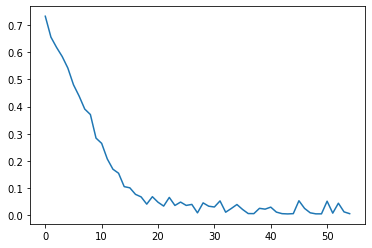

Epoch 1/100
22/22 - 5s - loss: 0.7371 - accuracy: 0.5539 - auc_14: 0.5904 - precision_14: 0.5530 - recall_14: 0.5000 - f1_score: 0.6607 - val_loss: 0.7168 - val_accuracy: 0.5067 - val_auc_14: 0.4695 - val_precision_14: 0.4286 - val_recall_14: 0.4688 - val_f1_score: 0.5981 - 5s/epoch - 238ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6404 - accuracy: 0.6396 - auc_14: 0.6869 - precision_14: 0.6308 - recall_14: 0.6497 - f1_score: 0.6607 - val_loss: 0.8571 - val_accuracy: 0.4933 - val_auc_14: 0.4695 - val_precision_14: 0.4211 - val_recall_14: 0.5000 - val_f1_score: 0.5981 - 933ms/epoch - 42ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6170 - accuracy: 0.6677 - auc_14: 0.7195 - precision_14: 0.6677 - recall_14: 0.6497 - f1_score: 0.6607 - val_loss: 0.7930 - val_accuracy: 0.4400 - val_auc_14: 0.4622 - val_precision_14: 0.3864 - val_recall_14: 0.5312 - val_f1_score: 0.5981 - 941ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5788 - accuracy: 0.7105 - auc_14: 0.7659 - precision_14: 0.6971 - recall

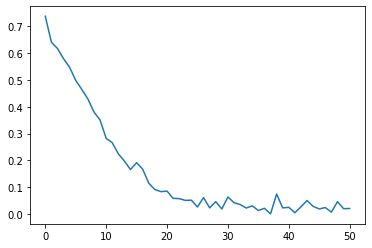

Epoch 1/100
22/22 - 5s - loss: 0.7383 - accuracy: 0.5968 - auc_15: 0.6064 - precision_15: 0.5959 - recall_15: 0.5289 - f1_score: 0.6541 - val_loss: 0.7230 - val_accuracy: 0.5067 - val_auc_15: 0.7059 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.6607 - 5s/epoch - 227ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6427 - accuracy: 0.6499 - auc_15: 0.6889 - precision_15: 0.6465 - recall_15: 0.6170 - f1_score: 0.6541 - val_loss: 0.7391 - val_accuracy: 0.5067 - val_auc_15: 0.6867 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.6607 - 918ms/epoch - 42ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6056 - accuracy: 0.6573 - auc_15: 0.7314 - precision_15: 0.6540 - recall_15: 0.6261 - f1_score: 0.6541 - val_loss: 0.7346 - val_accuracy: 0.5467 - val_auc_15: 0.6021 - val_precision_15: 1.0000 - val_recall_15: 0.0811 - val_f1_score: 0.6607 - 958ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5724 - accuracy: 0.7164 - auc_15: 0.7751 - precision_15:

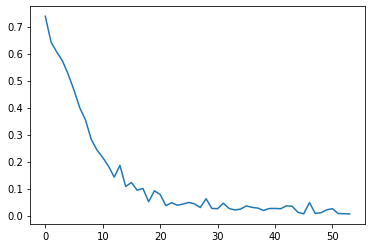

Epoch 1/100
22/22 - 5s - loss: 0.7930 - accuracy: 0.5938 - auc_16: 0.5912 - precision_16: 0.5856 - recall_16: 0.5873 - f1_score: 0.6581 - val_loss: 0.7576 - val_accuracy: 0.4533 - val_auc_16: 0.6220 - val_precision_16: 0.4533 - val_recall_16: 1.0000 - val_f1_score: 0.6239 - 5s/epoch - 229ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6520 - accuracy: 0.6204 - auc_16: 0.6705 - precision_16: 0.6190 - recall_16: 0.5873 - f1_score: 0.6581 - val_loss: 0.9850 - val_accuracy: 0.4533 - val_auc_16: 0.6377 - val_precision_16: 0.4533 - val_recall_16: 1.0000 - val_f1_score: 0.6239 - 906ms/epoch - 41ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6566 - accuracy: 0.6204 - auc_16: 0.6616 - precision_16: 0.6005 - recall_16: 0.6747 - f1_score: 0.6581 - val_loss: 0.6905 - val_accuracy: 0.6800 - val_auc_16: 0.6567 - val_precision_16: 0.6667 - val_recall_16: 0.5882 - val_f1_score: 0.6239 - 1s/epoch - 53ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6100 - accuracy: 0.6632 - auc_16: 0.7290 - precision_16: 0.6605 - recall_16

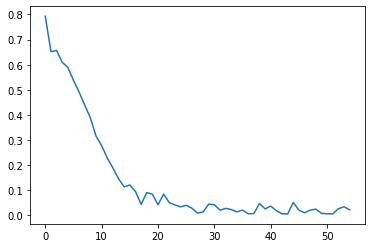

Epoch 1/100
22/22 - 5s - loss: 0.7976 - accuracy: 0.5805 - auc_17: 0.5942 - precision_17: 0.5802 - recall_17: 0.5136 - f1_score: 0.6567 - val_loss: 0.6981 - val_accuracy: 0.4800 - val_auc_17: 0.5586 - val_precision_17: 0.2500 - val_recall_17: 0.0571 - val_f1_score: 0.6364 - 5s/epoch - 237ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6437 - accuracy: 0.6366 - auc_17: 0.6824 - precision_17: 0.6358 - recall_17: 0.6012 - f1_score: 0.6567 - val_loss: 0.6639 - val_accuracy: 0.6533 - val_auc_17: 0.6311 - val_precision_17: 0.6216 - val_recall_17: 0.6571 - val_f1_score: 0.6364 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6168 - accuracy: 0.6662 - auc_17: 0.7215 - precision_17: 0.6636 - recall_17: 0.6435 - f1_score: 0.6567 - val_loss: 0.6846 - val_accuracy: 0.6267 - val_auc_17: 0.6800 - val_precision_17: 0.5636 - val_recall_17: 0.8857 - val_f1_score: 0.6364 - 948ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5833 - accuracy: 0.6987 - auc_17: 0.7556 - precision_17: 0.6779 - recall_17

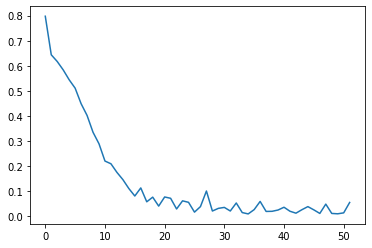

Epoch 1/100
22/22 - 5s - loss: 0.6972 - accuracy: 0.6056 - auc_18: 0.6452 - precision_18: 0.6028 - recall_18: 0.5231 - f1_score: 0.6487 - val_loss: 0.6829 - val_accuracy: 0.5467 - val_auc_18: 0.6402 - val_precision_18: 0.5467 - val_recall_18: 1.0000 - val_f1_score: 0.7069 - 5s/epoch - 227ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6406 - accuracy: 0.6337 - auc_18: 0.6923 - precision_18: 0.6230 - recall_18: 0.6000 - f1_score: 0.6487 - val_loss: 0.8284 - val_accuracy: 0.4533 - val_auc_18: 0.6237 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.7069 - 948ms/epoch - 43ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6226 - accuracy: 0.6617 - auc_18: 0.7112 - precision_18: 0.6633 - recall_18: 0.6000 - f1_score: 0.6487 - val_loss: 0.6713 - val_accuracy: 0.6267 - val_auc_18: 0.7127 - val_precision_18: 0.8421 - val_recall_18: 0.3902 - val_f1_score: 0.7069 - 1s/epoch - 51ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5789 - accuracy: 0.6898 - auc_18: 0.7648 - precision_18: 0.6910 - r

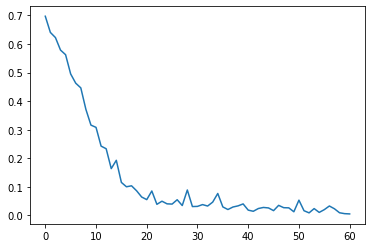

Epoch 1/100
22/22 - 5s - loss: 0.7480 - accuracy: 0.5849 - auc_19: 0.6012 - precision_19: 0.5818 - recall_19: 0.5731 - f1_score: 0.6621 - val_loss: 0.7990 - val_accuracy: 0.4133 - val_auc_19: 0.5451 - val_precision_19: 0.4133 - val_recall_19: 1.0000 - val_f1_score: 0.5849 - 5s/epoch - 223ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6383 - accuracy: 0.6544 - auc_19: 0.6918 - precision_19: 0.6490 - recall_19: 0.6567 - f1_score: 0.6621 - val_loss: 0.7731 - val_accuracy: 0.4133 - val_auc_19: 0.6360 - val_precision_19: 0.4133 - val_recall_19: 1.0000 - val_f1_score: 0.5849 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6135 - accuracy: 0.6617 - auc_19: 0.7246 - precision_19: 0.6480 - recall_19: 0.6925 - f1_score: 0.6621 - val_loss: 0.9714 - val_accuracy: 0.4400 - val_auc_19: 0.5077 - val_precision_19: 0.4225 - val_recall_19: 0.9677 - val_f1_score: 0.5849 - 906ms/epoch - 41ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5918 - accuracy: 0.6706 - auc_19: 0.7509 - precision_19: 0.6687 - recall_19

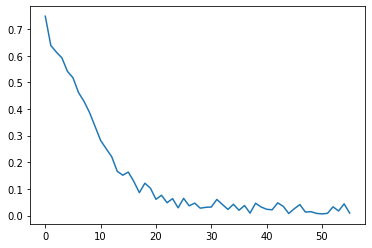

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_face_model = RCNN(n_features, None, n_length, n_outputs)
    history = rcnn_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_face_model.save(model_path / 'face_binary_rcnn.h5')

#### Training performance

In [ ]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.994238406419754,
 'ROC/AUC': 0.9997301220893859,
 'Precision': 0.993941605091095,
 'Recall': 0.994258451461792,
 'F1-score': 0.6547199666500092}

#### Validation performance

In [ ]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.676736843585968,
 'ROC/AUC': 0.70728799700737,
 'Precision': 0.6467603325843811,
 'Recall': 0.72708740234375,
 'F1-score': 0.6530827581882477}

#### Predictions and performance on test set

In [ ]:
rcnn_binary_face_model = load_model(model_path / 'face_binary_rcnn.h5')
y_pred = rcnn_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 15ms/step - loss: 0.9628 - accuracy: 0.6045 - auc_18: 0.6193 - precision_18: 0.9085 - recall_18: 0.6017 - f1_score: 0.9259
Accuracy: 60.45% 
ROC/AUC: 0.62 
Precision: 0.91 
Recall: 0.60 
F1 score: 0.93


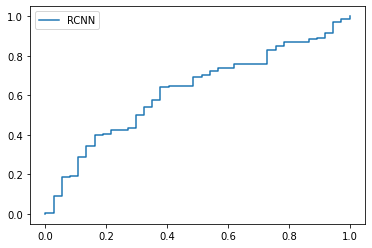

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

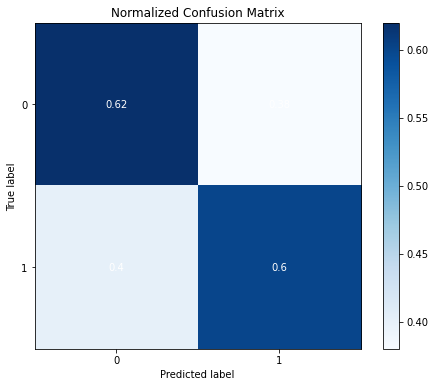

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

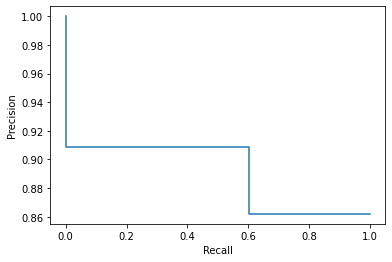

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## 3. Multimodal Early Fusion

In [ ]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 60) (752, 1)
(268, 1, 350, 60) (268, 1)


### 3.1 CNN + BiLSTM

Epoch 1/100
22/22 - 5s - loss: 0.7375 - accuracy: 0.5932 - auc_20: 0.6123 - precision_20: 0.5874 - recall_20: 0.5169 - f1_score: 0.6494 - val_loss: 0.7104 - val_accuracy: 0.4605 - val_auc_20: 0.6397 - val_precision_20: 0.5000 - val_recall_20: 0.0244 - val_f1_score: 0.7009 - 5s/epoch - 231ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6372 - accuracy: 0.6805 - auc_20: 0.6887 - precision_20: 0.7041 - recall_20: 0.5785 - f1_score: 0.6494 - val_loss: 0.7180 - val_accuracy: 0.5526 - val_auc_20: 0.6282 - val_precision_20: 0.6667 - val_recall_20: 0.3415 - val_f1_score: 0.7009 - 949ms/epoch - 43ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5965 - accuracy: 0.6997 - auc_20: 0.7341 - precision_20: 0.7328 - recall_20: 0.5908 - f1_score: 0.6494 - val_loss: 0.8117 - val_accuracy: 0.4737 - val_auc_20: 0.7383 - val_precision_20: 0.6667 - val_recall_20: 0.0488 - val_f1_score: 0.7009 - 949ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5621 - accuracy: 0.7175 - auc_20: 0.7762 - precision_20: 0.7428 - recall

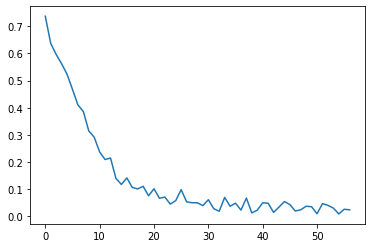

Epoch 1/100
22/22 - 5s - loss: 0.7709 - accuracy: 0.5680 - auc_21: 0.5718 - precision_21: 0.5572 - recall_21: 0.4675 - f1_score: 0.6466 - val_loss: 0.6728 - val_accuracy: 0.5263 - val_auc_21: 0.6589 - val_precision_21: 0.5593 - val_recall_21: 0.7674 - val_f1_score: 0.7227 - 5s/epoch - 242ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6607 - accuracy: 0.6139 - auc_21: 0.6443 - precision_21: 0.6115 - recall_21: 0.5263 - f1_score: 0.6466 - val_loss: 0.6897 - val_accuracy: 0.5132 - val_auc_21: 0.5944 - val_precision_21: 0.5577 - val_recall_21: 0.6744 - val_f1_score: 0.7227 - 954ms/epoch - 43ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6135 - accuracy: 0.6746 - auc_21: 0.7190 - precision_21: 0.6807 - recall_21: 0.6006 - f1_score: 0.6466 - val_loss: 0.6328 - val_accuracy: 0.5921 - val_auc_21: 0.6906 - val_precision_21: 0.6579 - val_recall_21: 0.5814 - val_f1_score: 0.7227 - 1s/epoch - 54ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5586 - accuracy: 0.7308 - auc_21: 0.7853 - precision_21: 0.7456 - recall_21

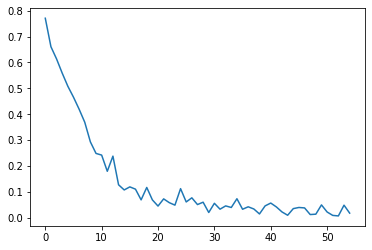

Epoch 1/100
22/22 - 5s - loss: 0.7783 - accuracy: 0.6041 - auc_22: 0.6154 - precision_22: 0.5994 - recall_22: 0.5813 - f1_score: 0.6581 - val_loss: 0.6780 - val_accuracy: 0.5467 - val_auc_22: 0.6169 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.6239 - 5s/epoch - 242ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6220 - accuracy: 0.6455 - auc_22: 0.6991 - precision_22: 0.6811 - recall_22: 0.5211 - f1_score: 0.6581 - val_loss: 0.9122 - val_accuracy: 0.5200 - val_auc_22: 0.6123 - val_precision_22: 0.4857 - val_recall_22: 1.0000 - val_f1_score: 0.6239 - 985ms/epoch - 45ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5806 - accuracy: 0.7016 - auc_22: 0.7601 - precision_22: 0.7083 - recall_22: 0.6657 - f1_score: 0.6581 - val_loss: 0.7448 - val_accuracy: 0.5600 - val_auc_22: 0.6438 - val_precision_22: 0.5143 - val_recall_22: 0.5294 - val_f1_score: 0.6239 - 952ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5577 - accuracy: 0.7149 - auc_22: 0.7761 - precision_22: 0.7356 

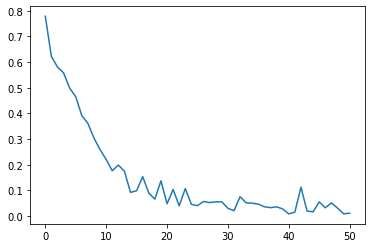

Epoch 1/100
22/22 - 5s - loss: 0.7367 - accuracy: 0.5716 - auc_23: 0.6096 - precision_23: 0.5556 - recall_23: 0.5793 - f1_score: 0.6527 - val_loss: 0.6899 - val_accuracy: 0.5067 - val_auc_23: 0.6518 - val_precision_23: 0.5067 - val_recall_23: 1.0000 - val_f1_score: 0.6726 - 5s/epoch - 222ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6324 - accuracy: 0.6425 - auc_23: 0.6916 - precision_23: 0.6525 - recall_23: 0.5610 - f1_score: 0.6527 - val_loss: 0.6734 - val_accuracy: 0.6000 - val_auc_23: 0.6863 - val_precision_23: 0.7222 - val_recall_23: 0.3421 - val_f1_score: 0.6726 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6002 - accuracy: 0.6706 - auc_23: 0.7401 - precision_23: 0.6882 - recall_23: 0.5854 - f1_score: 0.6527 - val_loss: 0.7222 - val_accuracy: 0.5067 - val_auc_23: 0.5864 - val_precision_23: 0.5067 - val_recall_23: 1.0000 - val_f1_score: 0.6726 - 1s/epoch - 46ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5698 - accuracy: 0.7031 - auc_23: 0.7731 - precision_23: 0.7096 - recall_23: 0

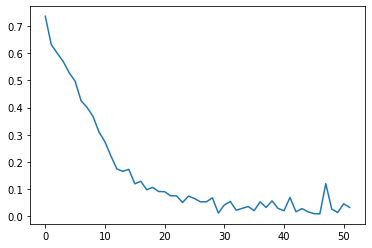

Epoch 1/100
22/22 - 5s - loss: 0.7033 - accuracy: 0.6086 - auc_24: 0.6368 - precision_24: 0.6062 - recall_24: 0.5898 - f1_score: 0.6607 - val_loss: 0.8551 - val_accuracy: 0.4667 - val_auc_24: 0.6137 - val_precision_24: 0.4429 - val_recall_24: 0.9688 - val_f1_score: 0.5981 - 5s/epoch - 234ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6456 - accuracy: 0.6588 - auc_24: 0.6909 - precision_24: 0.6594 - recall_24: 0.6377 - f1_score: 0.6607 - val_loss: 0.8164 - val_accuracy: 0.4267 - val_auc_24: 0.5200 - val_precision_24: 0.4267 - val_recall_24: 1.0000 - val_f1_score: 0.5981 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5941 - accuracy: 0.6898 - auc_24: 0.7444 - precision_24: 0.6856 - recall_24: 0.6856 - f1_score: 0.6607 - val_loss: 0.6954 - val_accuracy: 0.5600 - val_auc_24: 0.6145 - val_precision_24: 0.4865 - val_recall_24: 0.5625 - val_f1_score: 0.5981 - 1s/epoch - 53ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5588 - accuracy: 0.7149 - auc_24: 0.7828 - precision_24: 0.7390 - recall_24: 0

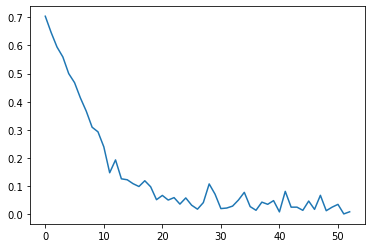

Epoch 1/100
22/22 - 5s - loss: 0.7587 - accuracy: 0.5790 - auc_25: 0.5961 - precision_25: 0.5724 - recall_25: 0.5289 - f1_score: 0.6541 - val_loss: 0.6619 - val_accuracy: 0.7067 - val_auc_25: 0.7226 - val_precision_25: 0.6316 - val_recall_25: 0.9730 - val_f1_score: 0.6607 - 5s/epoch - 223ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6438 - accuracy: 0.6440 - auc_25: 0.6730 - precision_25: 0.6507 - recall_25: 0.5775 - f1_score: 0.6541 - val_loss: 0.6560 - val_accuracy: 0.5600 - val_auc_25: 0.7525 - val_precision_25: 0.5312 - val_recall_25: 0.9189 - val_f1_score: 0.6607 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6077 - accuracy: 0.6898 - auc_25: 0.7286 - precision_25: 0.6926 - recall_25: 0.6505 - f1_score: 0.6541 - val_loss: 0.7448 - val_accuracy: 0.6000 - val_auc_25: 0.6803 - val_precision_25: 0.5614 - val_recall_25: 0.8649 - val_f1_score: 0.6607 - 965ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5898 - accuracy: 0.6898 - auc_25: 0.7543 - precision_25: 0.6854 - recall_25

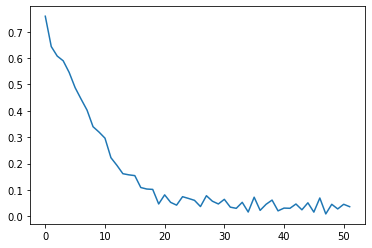

Epoch 1/100
22/22 - 5s - loss: 0.7837 - accuracy: 0.5849 - auc_26: 0.6014 - precision_26: 0.5876 - recall_26: 0.5151 - f1_score: 0.6581 - val_loss: 0.6094 - val_accuracy: 0.7200 - val_auc_26: 0.7461 - val_precision_26: 0.8421 - val_recall_26: 0.4706 - val_f1_score: 0.6239 - 5s/epoch - 241ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6379 - accuracy: 0.6470 - auc_26: 0.6870 - precision_26: 0.6576 - recall_26: 0.5843 - f1_score: 0.6581 - val_loss: 0.6244 - val_accuracy: 0.7200 - val_auc_26: 0.7281 - val_precision_26: 0.7826 - val_recall_26: 0.5294 - val_f1_score: 0.6239 - 926ms/epoch - 42ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6199 - accuracy: 0.6721 - auc_26: 0.7140 - precision_26: 0.6910 - recall_26: 0.5994 - f1_score: 0.6581 - val_loss: 0.6581 - val_accuracy: 0.6400 - val_auc_26: 0.6216 - val_precision_26: 0.6522 - val_recall_26: 0.4412 - val_f1_score: 0.6239 - 953ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5708 - accuracy: 0.7016 - auc_26: 0.7716 - precision_26: 0.7257 - recall

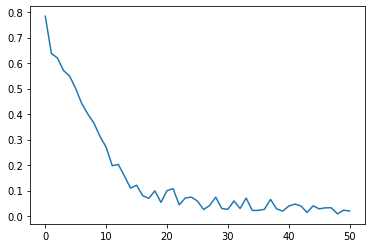

Epoch 1/100
22/22 - 5s - loss: 0.7393 - accuracy: 0.5982 - auc_27: 0.6318 - precision_27: 0.5955 - recall_27: 0.5559 - f1_score: 0.6567 - val_loss: 0.7340 - val_accuracy: 0.5333 - val_auc_27: 0.4479 - val_precision_27: 0.5000 - val_recall_27: 0.1429 - val_f1_score: 0.6364 - 5s/epoch - 232ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6136 - accuracy: 0.6677 - auc_27: 0.7124 - precision_27: 0.6893 - recall_27: 0.5831 - f1_score: 0.6567 - val_loss: 0.7477 - val_accuracy: 0.5200 - val_auc_27: 0.6232 - val_precision_27: 0.4000 - val_recall_27: 0.0571 - val_f1_score: 0.6364 - 924ms/epoch - 42ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5860 - accuracy: 0.6987 - auc_27: 0.7517 - precision_27: 0.7182 - recall_27: 0.6314 - f1_score: 0.6567 - val_loss: 0.9174 - val_accuracy: 0.5600 - val_auc_27: 0.6471 - val_precision_27: 0.5156 - val_recall_27: 0.9429 - val_f1_score: 0.6364 - 944ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5482 - accuracy: 0.7312 - auc_27: 0.7925 - precision_27: 0.7427 - recall

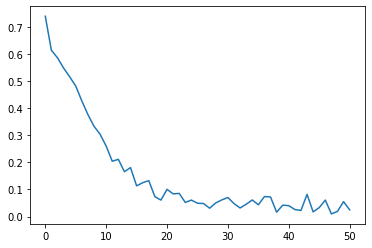

Epoch 1/100
22/22 - 5s - loss: 0.7026 - accuracy: 0.6056 - auc_28: 0.6274 - precision_28: 0.5948 - recall_28: 0.5600 - f1_score: 0.6487 - val_loss: 0.6982 - val_accuracy: 0.5200 - val_auc_28: 0.6481 - val_precision_28: 0.5373 - val_recall_28: 0.8780 - val_f1_score: 0.7069 - 5s/epoch - 227ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6400 - accuracy: 0.6352 - auc_28: 0.6869 - precision_28: 0.6266 - recall_28: 0.5938 - f1_score: 0.6487 - val_loss: 0.6822 - val_accuracy: 0.5867 - val_auc_28: 0.6424 - val_precision_28: 0.8125 - val_recall_28: 0.3171 - val_f1_score: 0.7069 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6138 - accuracy: 0.6603 - auc_28: 0.7240 - precision_28: 0.6547 - recall_28: 0.6185 - f1_score: 0.6487 - val_loss: 0.6384 - val_accuracy: 0.5733 - val_auc_28: 0.6897 - val_precision_28: 0.5882 - val_recall_28: 0.7317 - val_f1_score: 0.7069 - 1s/epoch - 53ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5796 - accuracy: 0.7046 - auc_28: 0.7627 - precision_28: 0.7063 - recall_28: 0

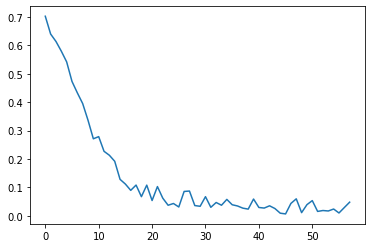

Epoch 1/100
22/22 - 5s - loss: 0.7642 - accuracy: 0.5849 - auc_29: 0.5983 - precision_29: 0.5944 - recall_29: 0.5075 - f1_score: 0.6621 - val_loss: 0.7297 - val_accuracy: 0.5867 - val_auc_29: 0.7126 - val_precision_29: 0.5000 - val_recall_29: 0.9032 - val_f1_score: 0.5849 - 5s/epoch - 240ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6327 - accuracy: 0.6647 - auc_29: 0.6961 - precision_29: 0.6742 - recall_29: 0.6239 - f1_score: 0.6621 - val_loss: 0.6618 - val_accuracy: 0.6267 - val_auc_29: 0.7185 - val_precision_29: 0.5319 - val_recall_29: 0.8065 - val_f1_score: 0.5849 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5933 - accuracy: 0.6883 - auc_29: 0.7480 - precision_29: 0.6975 - recall_29: 0.6537 - f1_score: 0.6621 - val_loss: 0.7862 - val_accuracy: 0.6000 - val_auc_29: 0.6782 - val_precision_29: 0.5094 - val_recall_29: 0.8710 - val_f1_score: 0.5849 - 945ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5594 - accuracy: 0.7016 - auc_29: 0.7822 - precision_29: 0.7111 - recall_29

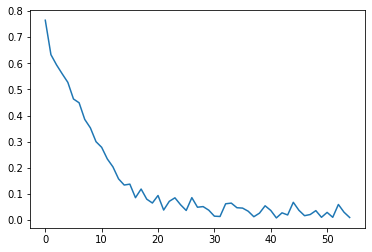

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_earlyfusion_model = CNNLSTM(n_features, None, n_length, n_outputs)
    history = cnnlstm_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_earlyfusion_model.save(model_path / 'early_binary_cnnlstm.h5')

#### Training performance

In [ ]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.9915785431861878,
 'ROC/AUC': 0.999561733007431,
 'Precision': 0.989095538854599,
 'Recall': 0.9935961246490479,
 'F1-score': 0.6547199666500092}

#### Validation performance

In [ ]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.6742105305194854,
 'ROC/AUC': 0.7326578080654145,
 'Precision': 0.6591229736804962,
 'Recall': 0.6971023619174957,
 'F1-score': 0.6530827581882477}

#### Predictions and performance on test set

In [ ]:
cnnlstm_binary_earlyfusion_model = load_model(model_path / 'early_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_earlyfusion_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 15ms/step - loss: 0.8498 - accuracy: 0.3955 - auc_26: 0.6565 - precision_26: 0.9367 - recall_26: 0.3203 - f1_score: 0.9259
Accuracy: 39.55% 
ROC/AUC: 0.66 
Precision: 0.94 
Recall: 0.32 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

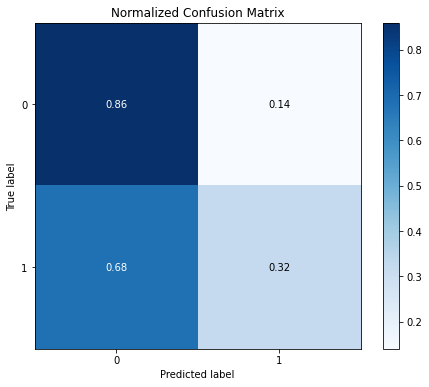

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

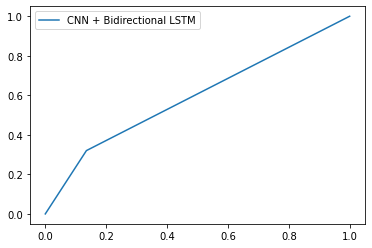

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

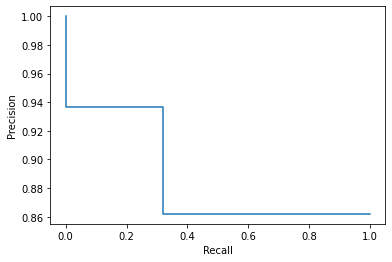

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 3.2 RCNN

Epoch 1/100
22/22 - 5s - loss: 0.7821 - accuracy: 0.6050 - auc_30: 0.6256 - precision_30: 0.5912 - recall_30: 0.5785 - f1_score: 0.6494 - val_loss: 1.0569 - val_accuracy: 0.5395 - val_auc_30: 0.6150 - val_precision_30: 0.5395 - val_recall_30: 1.0000 - val_f1_score: 0.7009 - 5s/epoch - 243ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6419 - accuracy: 0.6420 - auc_30: 0.6836 - precision_30: 0.6436 - recall_30: 0.5723 - f1_score: 0.6494 - val_loss: 0.6373 - val_accuracy: 0.5921 - val_auc_30: 0.6941 - val_precision_30: 0.6087 - val_recall_30: 0.6829 - val_f1_score: 0.7009 - 1s/epoch - 55ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5884 - accuracy: 0.6982 - auc_30: 0.7493 - precision_30: 0.7108 - recall_30: 0.6277 - f1_score: 0.6494 - val_loss: 0.7079 - val_accuracy: 0.5921 - val_auc_30: 0.6408 - val_precision_30: 0.5962 - val_recall_30: 0.7561 - val_f1_score: 0.7009 - 951ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5542 - accuracy: 0.7337 - auc_30: 0.7807 - precision_30: 0.7757 - recall_30

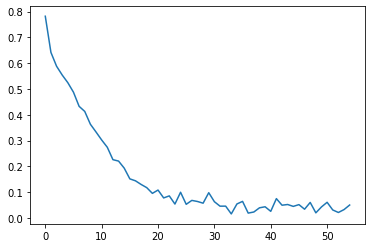

Epoch 1/100
22/22 - 5s - loss: 0.7566 - accuracy: 0.5473 - auc_31: 0.5786 - precision_31: 0.5275 - recall_31: 0.5046 - f1_score: 0.6466 - val_loss: 0.7065 - val_accuracy: 0.5132 - val_auc_31: 0.5634 - val_precision_31: 0.6154 - val_recall_31: 0.3721 - val_f1_score: 0.7227 - 5s/epoch - 238ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6354 - accuracy: 0.6346 - auc_31: 0.6999 - precision_31: 0.6234 - recall_31: 0.5944 - f1_score: 0.6466 - val_loss: 0.6485 - val_accuracy: 0.6184 - val_auc_31: 0.7907 - val_precision_31: 0.8500 - val_recall_31: 0.3953 - val_f1_score: 0.7227 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6051 - accuracy: 0.6598 - auc_31: 0.7316 - precision_31: 0.6545 - recall_31: 0.6099 - f1_score: 0.6466 - val_loss: 0.7349 - val_accuracy: 0.4868 - val_auc_31: 0.7033 - val_precision_31: 1.0000 - val_recall_31: 0.0930 - val_f1_score: 0.7227 - 925ms/epoch - 42ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5414 - accuracy: 0.7367 - auc_31: 0.8022 - precision_31: 0.7656 - recall_31

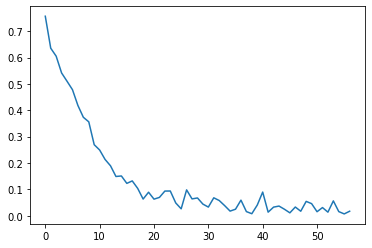

Epoch 1/100
22/22 - 5s - loss: 0.7595 - accuracy: 0.6100 - auc_32: 0.6149 - precision_32: 0.6141 - recall_32: 0.5512 - f1_score: 0.6581 - val_loss: 0.9135 - val_accuracy: 0.4667 - val_auc_32: 0.6374 - val_precision_32: 0.4583 - val_recall_32: 0.9706 - val_f1_score: 0.6239 - 5s/epoch - 239ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6418 - accuracy: 0.6558 - auc_32: 0.6907 - precision_32: 0.6713 - recall_32: 0.5843 - f1_score: 0.6581 - val_loss: 0.8086 - val_accuracy: 0.4400 - val_auc_32: 0.6711 - val_precision_32: 0.4459 - val_recall_32: 0.9706 - val_f1_score: 0.6239 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5889 - accuracy: 0.6928 - auc_32: 0.7536 - precision_32: 0.6925 - recall_32: 0.6717 - f1_score: 0.6581 - val_loss: 0.8965 - val_accuracy: 0.5067 - val_auc_32: 0.7091 - val_precision_32: 0.4789 - val_recall_32: 1.0000 - val_f1_score: 0.6239 - 960ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5495 - accuracy: 0.7297 - auc_32: 0.7912 - precision_32: 0.7350 - recall_32

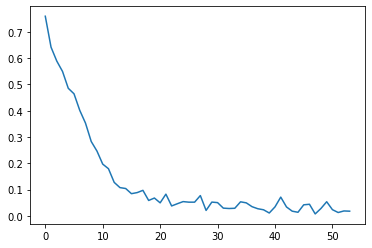

Epoch 1/100
22/22 - 5s - loss: 0.7400 - accuracy: 0.6012 - auc_33: 0.6124 - precision_33: 0.6043 - recall_33: 0.5122 - f1_score: 0.6527 - val_loss: 0.6652 - val_accuracy: 0.6000 - val_auc_33: 0.6291 - val_precision_33: 0.5952 - val_recall_33: 0.6579 - val_f1_score: 0.6726 - 5s/epoch - 233ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6209 - accuracy: 0.6691 - auc_33: 0.7154 - precision_33: 0.6844 - recall_33: 0.5884 - f1_score: 0.6527 - val_loss: 0.7398 - val_accuracy: 0.5867 - val_auc_33: 0.6984 - val_precision_33: 0.5538 - val_recall_33: 0.9474 - val_f1_score: 0.6726 - 949ms/epoch - 43ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5816 - accuracy: 0.7120 - auc_33: 0.7601 - precision_33: 0.7270 - recall_33: 0.6494 - f1_score: 0.6527 - val_loss: 1.0731 - val_accuracy: 0.5067 - val_auc_33: 0.5917 - val_precision_33: 0.5067 - val_recall_33: 1.0000 - val_f1_score: 0.6726 - 976ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5577 - accuracy: 0.7297 - auc_33: 0.7851 - precision_33: 0.7346 - recall

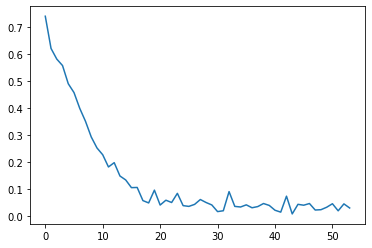

Epoch 1/100
22/22 - 5s - loss: 0.7594 - accuracy: 0.5835 - auc_34: 0.5982 - precision_34: 0.5802 - recall_34: 0.5629 - f1_score: 0.6607 - val_loss: 0.6808 - val_accuracy: 0.6400 - val_auc_34: 0.5556 - val_precision_34: 0.7273 - val_recall_34: 0.2500 - val_f1_score: 0.5981 - 5s/epoch - 226ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6360 - accuracy: 0.6617 - auc_34: 0.6941 - precision_34: 0.6780 - recall_34: 0.5988 - f1_score: 0.6607 - val_loss: 0.8072 - val_accuracy: 0.4267 - val_auc_34: 0.6141 - val_precision_34: 0.4267 - val_recall_34: 1.0000 - val_f1_score: 0.5981 - 942ms/epoch - 43ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5805 - accuracy: 0.7134 - auc_34: 0.7610 - precision_34: 0.7188 - recall_34: 0.6886 - f1_score: 0.6607 - val_loss: 0.7166 - val_accuracy: 0.6400 - val_auc_34: 0.5610 - val_precision_34: 0.6190 - val_recall_34: 0.4062 - val_f1_score: 0.5981 - 960ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5421 - accuracy: 0.7164 - auc_34: 0.7964 - precision_34: 0.7336 - recall

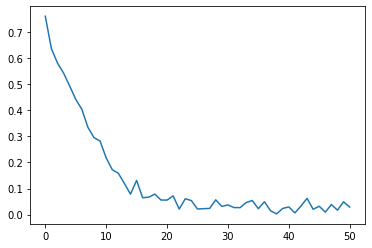

Epoch 1/100
22/22 - 5s - loss: 0.7097 - accuracy: 0.5923 - auc_35: 0.6350 - precision_35: 0.5898 - recall_35: 0.5289 - f1_score: 0.6541 - val_loss: 0.7546 - val_accuracy: 0.4933 - val_auc_35: 0.7770 - val_precision_35: 0.4933 - val_recall_35: 1.0000 - val_f1_score: 0.6607 - 5s/epoch - 241ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6380 - accuracy: 0.6440 - auc_35: 0.6850 - precision_35: 0.6419 - recall_35: 0.6049 - f1_score: 0.6541 - val_loss: 0.6360 - val_accuracy: 0.6533 - val_auc_35: 0.7237 - val_precision_35: 0.7037 - val_recall_35: 0.5135 - val_f1_score: 0.6607 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5919 - accuracy: 0.6869 - auc_35: 0.7454 - precision_35: 0.7053 - recall_35: 0.6109 - f1_score: 0.6541 - val_loss: 0.6421 - val_accuracy: 0.5733 - val_auc_35: 0.7646 - val_precision_35: 0.6923 - val_recall_35: 0.2432 - val_f1_score: 0.6607 - 947ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5662 - accuracy: 0.7134 - auc_35: 0.7740 - precision_35: 0.7320 - recall_35

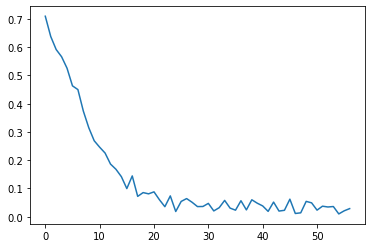

Epoch 1/100
22/22 - 5s - loss: 0.7547 - accuracy: 0.5657 - auc_36: 0.5798 - precision_36: 0.5638 - recall_36: 0.5060 - f1_score: 0.6581 - val_loss: 0.6465 - val_accuracy: 0.7067 - val_auc_36: 0.6697 - val_precision_36: 0.7000 - val_recall_36: 0.6176 - val_f1_score: 0.6239 - 5s/epoch - 224ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6554 - accuracy: 0.6233 - auc_36: 0.6549 - precision_36: 0.6262 - recall_36: 0.5753 - f1_score: 0.6581 - val_loss: 0.7469 - val_accuracy: 0.4667 - val_auc_36: 0.7496 - val_precision_36: 0.4595 - val_recall_36: 1.0000 - val_f1_score: 0.6239 - 971ms/epoch - 44ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6169 - accuracy: 0.6617 - auc_36: 0.7214 - precision_36: 0.6645 - recall_36: 0.6265 - f1_score: 0.6581 - val_loss: 0.9725 - val_accuracy: 0.4533 - val_auc_36: 0.7349 - val_precision_36: 0.4533 - val_recall_36: 1.0000 - val_f1_score: 0.6239 - 957ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5821 - accuracy: 0.7134 - auc_36: 0.7625 - precision_36: 0.7104 - recall

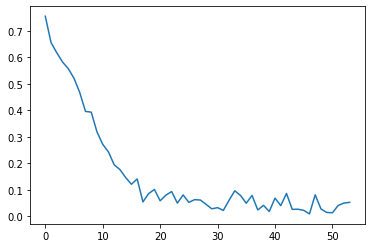

Epoch 1/100
22/22 - 5s - loss: 0.6950 - accuracy: 0.6160 - auc_37: 0.6622 - precision_37: 0.6141 - recall_37: 0.5770 - f1_score: 0.6567 - val_loss: 0.7639 - val_accuracy: 0.5067 - val_auc_37: 0.6432 - val_precision_37: 0.4861 - val_recall_37: 1.0000 - val_f1_score: 0.6364 - 5s/epoch - 242ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6239 - accuracy: 0.6588 - auc_37: 0.7074 - precision_37: 0.6613 - recall_37: 0.6193 - f1_score: 0.6567 - val_loss: 0.6911 - val_accuracy: 0.5333 - val_auc_37: 0.5907 - val_precision_37: 0.5000 - val_recall_37: 0.0857 - val_f1_score: 0.6364 - 1s/epoch - 52ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5748 - accuracy: 0.7149 - auc_37: 0.7672 - precision_37: 0.7331 - recall_37: 0.6556 - f1_score: 0.6567 - val_loss: 0.7036 - val_accuracy: 0.5200 - val_auc_37: 0.5864 - val_precision_37: 0.4921 - val_recall_37: 0.8857 - val_f1_score: 0.6364 - 910ms/epoch - 41ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5384 - accuracy: 0.7445 - auc_37: 0.8065 - precision_37: 0.7651 - recall_37

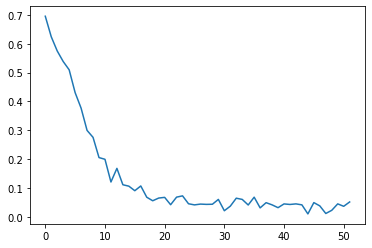

Epoch 1/100
22/22 - 5s - loss: 0.7630 - accuracy: 0.5953 - auc_38: 0.5974 - precision_38: 0.6016 - recall_38: 0.4646 - f1_score: 0.6487 - val_loss: 0.6592 - val_accuracy: 0.5467 - val_auc_38: 0.6908 - val_precision_38: 0.5522 - val_recall_38: 0.9024 - val_f1_score: 0.7069 - 5s/epoch - 226ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6266 - accuracy: 0.6558 - auc_38: 0.7008 - precision_38: 0.6503 - recall_38: 0.6123 - f1_score: 0.6487 - val_loss: 0.6432 - val_accuracy: 0.6533 - val_auc_38: 0.7012 - val_precision_38: 0.6667 - val_recall_38: 0.7317 - val_f1_score: 0.7069 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6004 - accuracy: 0.7016 - auc_38: 0.7373 - precision_38: 0.6952 - recall_38: 0.6738 - f1_score: 0.6487 - val_loss: 0.6857 - val_accuracy: 0.6000 - val_auc_38: 0.6998 - val_precision_38: 0.8235 - val_recall_38: 0.3415 - val_f1_score: 0.7069 - 910ms/epoch - 41ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5640 - accuracy: 0.7194 - auc_38: 0.7726 - precision_38: 0.7586 - recall_38

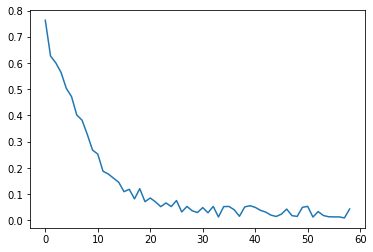

Epoch 1/100
22/22 - 5s - loss: 0.7369 - accuracy: 0.5672 - auc_39: 0.5967 - precision_39: 0.5597 - recall_39: 0.5881 - f1_score: 0.6621 - val_loss: 0.7840 - val_accuracy: 0.4133 - val_auc_39: 0.6470 - val_precision_39: 0.4133 - val_recall_39: 1.0000 - val_f1_score: 0.5849 - 5s/epoch - 242ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6459 - accuracy: 0.6499 - auc_39: 0.6781 - precision_39: 0.6354 - recall_39: 0.6866 - f1_score: 0.6621 - val_loss: 0.6674 - val_accuracy: 0.5867 - val_auc_39: 0.6499 - val_precision_39: 0.5000 - val_recall_39: 0.6452 - val_f1_score: 0.5849 - 1s/epoch - 53ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6053 - accuracy: 0.6750 - auc_39: 0.7408 - precision_39: 0.6803 - recall_39: 0.6478 - f1_score: 0.6621 - val_loss: 0.6938 - val_accuracy: 0.5867 - val_auc_39: 0.7038 - val_precision_39: 0.5000 - val_recall_39: 0.8387 - val_f1_score: 0.5849 - 918ms/epoch - 42ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5548 - accuracy: 0.7194 - auc_39: 0.7878 - precision_39: 0.7331 - recall_39

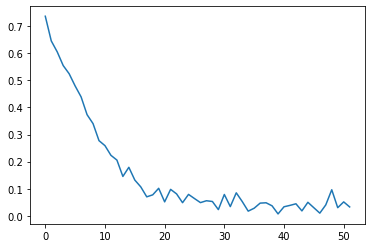

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_earlyfusion_model = RCNN(n_features, None, n_length, n_outputs)
    history = rcnn_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_earlyfusion_model.save(model_path / 'early_binary_rcnn.h5')

#### Training performance

In [ ]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.9895092904567718,
 'ROC/AUC': 0.9983950555324554,
 'Precision': 0.9878998458385467,
 'Recall': 0.9905698537826538,
 'F1-score': 0.6547199666500092}

#### Validation performance

In [ ]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.7046315848827363,
 'ROC/AUC': 0.7542568206787109,
 'Precision': 0.7003504276275635,
 'Recall': 0.6874718129634857,
 'F1-score': 0.6530827581882477}

#### Predictions and performance on test set

In [ ]:
rcnn_binary_earlyfusion_model = load_model(model_path / 'early_binary_rcnn.h5')
y_pred = rcnn_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_earlyfusion_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 17ms/step - loss: 0.7909 - accuracy: 0.4552 - auc_30: 0.6591 - precision_30: 0.9293 - recall_30: 0.3983 - f1_score: 0.9259
Accuracy: 45.52% 
ROC/AUC: 0.66 
Precision: 0.93 
Recall: 0.40 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

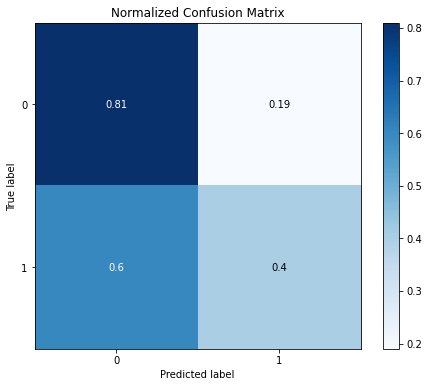

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

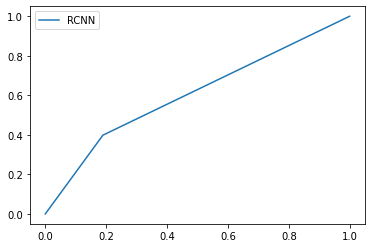

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

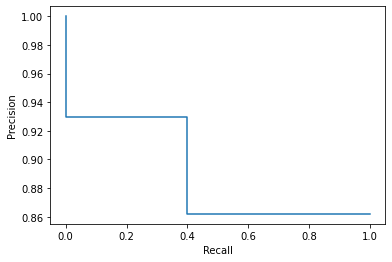

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## 4. Multimodal Late Fusion

In [ ]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', binary=True, fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(752, 1, 350, 35) (752, 1)
(268, 1, 350, 35) (268, 1)


In [ ]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', binary=True)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(752, 1, 350, 25) (752, 1)
(268, 1, 350, 25) (268, 1)


In [ ]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### 4.1 CNN + BiLSTM (Concatenation)

Epoch 1/100
22/22 - 9s - loss: 0.6984 - accuracy: 0.5873 - auc_1: 0.6101 - precision_1: 0.5752 - recall_1: 0.5415 - f1_score: 0.6494 - val_loss: 0.8586 - val_accuracy: 0.4605 - val_auc_1: 0.7000 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.7009 - 9s/epoch - 424ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6313 - accuracy: 0.6598 - auc_1: 0.7017 - precision_1: 0.6740 - recall_1: 0.5662 - f1_score: 0.6494 - val_loss: 0.6927 - val_accuracy: 0.5263 - val_auc_1: 0.6756 - val_precision_1: 0.8571 - val_recall_1: 0.1463 - val_f1_score: 0.7009 - 1s/epoch - 46ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5842 - accuracy: 0.6967 - auc_1: 0.7587 - precision_1: 0.7055 - recall_1: 0.6338 - f1_score: 0.6494 - val_loss: 0.6410 - val_accuracy: 0.6053 - val_auc_1: 0.7721 - val_precision_1: 0.8667 - val_recall_1: 0.3171 - val_f1_score: 0.7009 - 997ms/epoch - 45ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5592 - accuracy: 0.7263 - auc_1: 0.7880 - precision_1: 0.7215 - recall_1: 0.7015 - f1

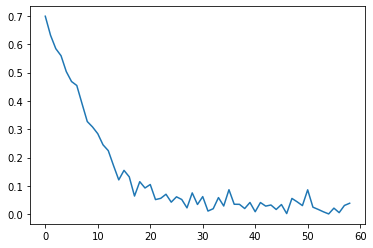

Epoch 1/100
22/22 - 6s - loss: 0.7117 - accuracy: 0.5932 - auc_2: 0.6055 - precision_2: 0.5828 - recall_2: 0.5232 - f1_score: 0.6466 - val_loss: 0.7355 - val_accuracy: 0.5658 - val_auc_2: 0.7301 - val_precision_2: 0.5658 - val_recall_2: 1.0000 - val_f1_score: 0.7227 - 6s/epoch - 260ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6389 - accuracy: 0.6538 - auc_2: 0.6883 - precision_2: 0.6361 - recall_2: 0.6440 - f1_score: 0.6466 - val_loss: 0.6503 - val_accuracy: 0.6184 - val_auc_2: 0.6769 - val_precision_2: 0.5972 - val_recall_2: 1.0000 - val_f1_score: 0.7227 - 959ms/epoch - 44ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5913 - accuracy: 0.6775 - auc_2: 0.7477 - precision_2: 0.6688 - recall_2: 0.6440 - f1_score: 0.6466 - val_loss: 0.6443 - val_accuracy: 0.6053 - val_auc_2: 0.7523 - val_precision_2: 0.5890 - val_recall_2: 1.0000 - val_f1_score: 0.7227 - 998ms/epoch - 45ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5618 - accuracy: 0.7219 - auc_2: 0.7857 - precision_2: 0.7103 - recall_2: 0.7059 - f1_scor

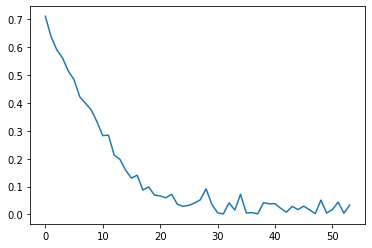

Epoch 1/100
22/22 - 6s - loss: 0.7083 - accuracy: 0.5849 - auc_3: 0.6145 - precision_3: 0.5847 - recall_3: 0.5301 - f1_score: 0.6581 - val_loss: 0.7737 - val_accuracy: 0.4533 - val_auc_3: 0.5825 - val_precision_3: 0.4521 - val_recall_3: 0.9706 - val_f1_score: 0.6239 - 6s/epoch - 250ms/step
Epoch 2/100
22/22 - 1s - loss: 0.5921 - accuracy: 0.7075 - auc_3: 0.7498 - precision_3: 0.7018 - recall_3: 0.7018 - f1_score: 0.6581 - val_loss: 0.6959 - val_accuracy: 0.5600 - val_auc_3: 0.4961 - val_precision_3: 0.5263 - val_recall_3: 0.2941 - val_f1_score: 0.6239 - 935ms/epoch - 42ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5704 - accuracy: 0.6942 - auc_3: 0.7697 - precision_3: 0.6923 - recall_3: 0.6777 - f1_score: 0.6581 - val_loss: 0.7466 - val_accuracy: 0.4800 - val_auc_3: 0.6241 - val_precision_3: 0.4627 - val_recall_3: 0.9118 - val_f1_score: 0.6239 - 834ms/epoch - 38ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5604 - accuracy: 0.7179 - auc_3: 0.7859 - precision_3: 0.6997 - recall_3: 0.7440 - f1_scor

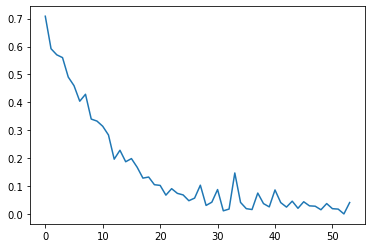

Epoch 1/100
22/22 - 6s - loss: 0.7109 - accuracy: 0.5982 - auc_4: 0.6244 - precision_4: 0.5886 - recall_4: 0.5671 - f1_score: 0.6527 - val_loss: 0.7305 - val_accuracy: 0.4933 - val_auc_4: 0.7386 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.6726 - 6s/epoch - 266ms/step
Epoch 2/100
22/22 - 1s - loss: 0.5979 - accuracy: 0.6913 - auc_4: 0.7452 - precision_4: 0.7073 - recall_4: 0.6189 - f1_score: 0.6527 - val_loss: 0.6153 - val_accuracy: 0.6933 - val_auc_4: 0.7539 - val_precision_4: 0.6923 - val_recall_4: 0.7105 - val_f1_score: 0.6726 - 998ms/epoch - 45ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5672 - accuracy: 0.6972 - auc_4: 0.7730 - precision_4: 0.7071 - recall_4: 0.6402 - f1_score: 0.6527 - val_loss: 0.7665 - val_accuracy: 0.5200 - val_auc_4: 0.6903 - val_precision_4: 0.5139 - val_recall_4: 0.9737 - val_f1_score: 0.6726 - 852ms/epoch - 39ms/step
Epoch 4/100
22/22 - 1s - loss: 0.4998 - accuracy: 0.7740 - auc_4: 0.8381 - precision_4: 0.7692 - recall_4: 0.7622 -

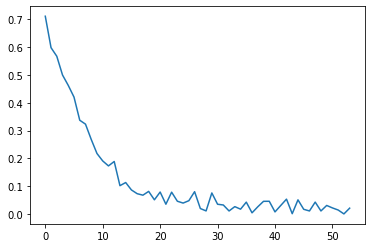

Epoch 1/100
22/22 - 6s - loss: 0.7129 - accuracy: 0.5835 - auc_5: 0.6188 - precision_5: 0.5929 - recall_5: 0.4970 - f1_score: 0.6607 - val_loss: 0.6999 - val_accuracy: 0.5733 - val_auc_5: 0.5167 - val_precision_5: 0.5000 - val_recall_5: 0.4688 - val_f1_score: 0.5981 - 6s/epoch - 262ms/step
Epoch 2/100
22/22 - 1s - loss: 0.5950 - accuracy: 0.6662 - auc_5: 0.7425 - precision_5: 0.6627 - recall_5: 0.6587 - f1_score: 0.6607 - val_loss: 0.6832 - val_accuracy: 0.6133 - val_auc_5: 0.6025 - val_precision_5: 0.5517 - val_recall_5: 0.5000 - val_f1_score: 0.5981 - 926ms/epoch - 42ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5522 - accuracy: 0.7090 - auc_5: 0.7874 - precision_5: 0.7161 - recall_5: 0.6796 - f1_score: 0.6607 - val_loss: 0.8273 - val_accuracy: 0.4667 - val_auc_5: 0.5799 - val_precision_5: 0.4394 - val_recall_5: 0.9062 - val_f1_score: 0.5981 - 878ms/epoch - 40ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5102 - accuracy: 0.7474 - auc_5: 0.8288 - precision_5: 0.7433 - recall_5: 0.7455 - f1_scor

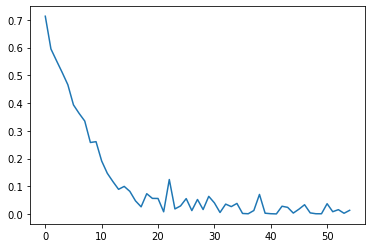

Epoch 1/100
22/22 - 6s - loss: 0.7818 - accuracy: 0.5805 - auc_6: 0.6028 - precision_6: 0.5728 - recall_6: 0.5380 - f1_score: 0.6541 - val_loss: 0.6742 - val_accuracy: 0.5733 - val_auc_6: 0.6305 - val_precision_6: 0.5532 - val_recall_6: 0.7027 - val_f1_score: 0.6607 - 6s/epoch - 252ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6215 - accuracy: 0.6544 - auc_6: 0.7111 - precision_6: 0.6537 - recall_6: 0.6140 - f1_score: 0.6541 - val_loss: 0.6531 - val_accuracy: 0.5733 - val_auc_6: 0.6643 - val_precision_6: 0.5556 - val_recall_6: 0.6757 - val_f1_score: 0.6607 - 951ms/epoch - 43ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5841 - accuracy: 0.6765 - auc_6: 0.7514 - precision_6: 0.6786 - recall_6: 0.6353 - f1_score: 0.6541 - val_loss: 0.6389 - val_accuracy: 0.6533 - val_auc_6: 0.7041 - val_precision_6: 0.6279 - val_recall_6: 0.7297 - val_f1_score: 0.6607 - 969ms/epoch - 44ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5259 - accuracy: 0.7297 - auc_6: 0.8090 - precision_6: 0.7226 - recall_6: 0.7204 - f1_scor

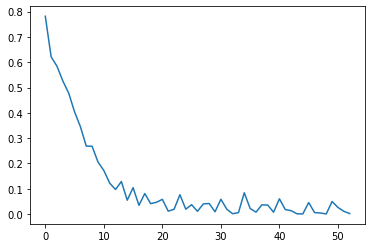

Epoch 1/100
22/22 - 6s - loss: 0.6965 - accuracy: 0.6056 - auc_7: 0.6328 - precision_7: 0.5976 - recall_7: 0.5994 - f1_score: 0.6581 - val_loss: 0.6433 - val_accuracy: 0.6000 - val_auc_7: 0.7123 - val_precision_7: 0.5909 - val_recall_7: 0.3824 - val_f1_score: 0.6239 - 6s/epoch - 251ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6128 - accuracy: 0.6780 - auc_7: 0.7256 - precision_7: 0.6827 - recall_7: 0.6416 - f1_score: 0.6581 - val_loss: 0.7219 - val_accuracy: 0.5467 - val_auc_7: 0.6822 - val_precision_7: 0.5000 - val_recall_7: 0.9412 - val_f1_score: 0.6239 - 861ms/epoch - 39ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5931 - accuracy: 0.6972 - auc_7: 0.7517 - precision_7: 0.6918 - recall_7: 0.6898 - f1_score: 0.6581 - val_loss: 0.8964 - val_accuracy: 0.5467 - val_auc_7: 0.7220 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.6239 - 827ms/epoch - 38ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5761 - accuracy: 0.6750 - auc_7: 0.7643 - precision_7: 0.6842 - recall_7: 0.6265 -

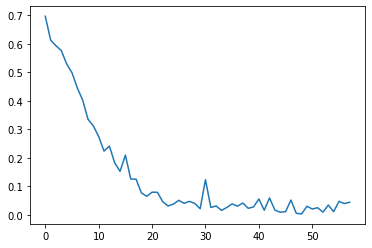

Epoch 1/100
22/22 - 6s - loss: 0.7007 - accuracy: 0.6041 - auc_8: 0.6154 - precision_8: 0.6075 - recall_8: 0.5378 - f1_score: 0.6567 - val_loss: 0.8436 - val_accuracy: 0.4667 - val_auc_8: 0.6643 - val_precision_8: 0.4667 - val_recall_8: 1.0000 - val_f1_score: 0.6364 - 6s/epoch - 261ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6155 - accuracy: 0.6795 - auc_8: 0.7252 - precision_8: 0.6759 - recall_8: 0.6616 - f1_score: 0.6567 - val_loss: 0.6701 - val_accuracy: 0.5333 - val_auc_8: 0.6532 - val_precision_8: 0.5000 - val_recall_8: 0.1429 - val_f1_score: 0.6364 - 948ms/epoch - 43ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5677 - accuracy: 0.7016 - auc_8: 0.7773 - precision_8: 0.6997 - recall_8: 0.6828 - f1_score: 0.6567 - val_loss: 0.6597 - val_accuracy: 0.6400 - val_auc_8: 0.6707 - val_precision_8: 0.5952 - val_recall_8: 0.7143 - val_f1_score: 0.6364 - 1s/epoch - 46ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5195 - accuracy: 0.7430 - auc_8: 0.8220 - precision_8: 0.7415 - recall_8: 0.7281 - f1_score: 

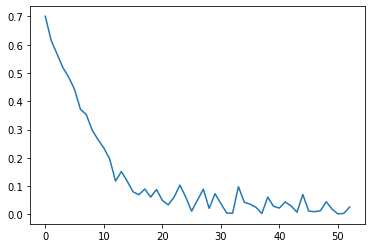

Epoch 1/100
22/22 - 6s - loss: 0.7122 - accuracy: 0.5835 - auc_9: 0.6059 - precision_9: 0.5734 - recall_9: 0.5169 - f1_score: 0.6487 - val_loss: 0.6904 - val_accuracy: 0.5467 - val_auc_9: 0.5646 - val_precision_9: 0.5593 - val_recall_9: 0.8049 - val_f1_score: 0.7069 - 6s/epoch - 264ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6365 - accuracy: 0.6352 - auc_9: 0.6874 - precision_9: 0.6309 - recall_9: 0.5785 - f1_score: 0.6487 - val_loss: 0.6991 - val_accuracy: 0.5200 - val_auc_9: 0.6248 - val_precision_9: 0.5455 - val_recall_9: 0.7317 - val_f1_score: 0.7069 - 896ms/epoch - 41ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6008 - accuracy: 0.6750 - auc_9: 0.7354 - precision_9: 0.6636 - recall_9: 0.6554 - f1_score: 0.6487 - val_loss: 0.6671 - val_accuracy: 0.5733 - val_auc_9: 0.6492 - val_precision_9: 0.6552 - val_recall_9: 0.4634 - val_f1_score: 0.7069 - 954ms/epoch - 43ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5787 - accuracy: 0.7090 - auc_9: 0.7653 - precision_9: 0.6963 - recall_9: 0.6985 - f1_scor

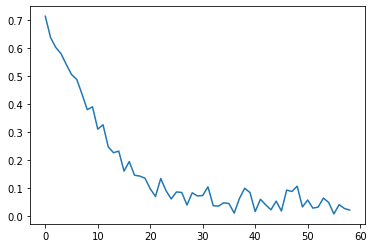

Epoch 1/100
22/22 - 6s - loss: 0.6984 - accuracy: 0.5761 - auc_10: 0.6066 - precision_10: 0.5755 - recall_10: 0.5463 - f1_score: 0.6621 - val_loss: 0.8554 - val_accuracy: 0.4133 - val_auc_10: 0.7199 - val_precision_10: 0.4133 - val_recall_10: 1.0000 - val_f1_score: 0.5849 - 6s/epoch - 261ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6204 - accuracy: 0.6824 - auc_10: 0.7151 - precision_10: 0.6667 - recall_10: 0.7164 - f1_score: 0.6621 - val_loss: 0.6512 - val_accuracy: 0.6267 - val_auc_10: 0.6697 - val_precision_10: 0.5600 - val_recall_10: 0.4516 - val_f1_score: 0.5849 - 961ms/epoch - 44ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5813 - accuracy: 0.6824 - auc_10: 0.7613 - precision_10: 0.6714 - recall_10: 0.7015 - f1_score: 0.6621 - val_loss: 0.7791 - val_accuracy: 0.5867 - val_auc_10: 0.6822 - val_precision_10: 0.5000 - val_recall_10: 0.0323 - val_f1_score: 0.5849 - 845ms/epoch - 38ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5297 - accuracy: 0.7326 - auc_10: 0.8117 - precision_10: 0.7362 - recall

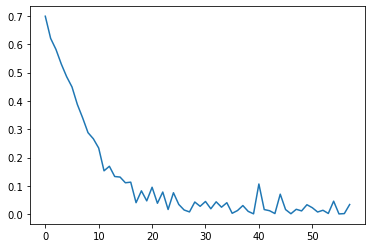

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_latefusion_model = CNNLSTM(body_features, face_features, n_length, n_outputs, fusion=True)
    history = cnnlstm_binary_latefusion_model.trainFusioned(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_latefusion_model.save(model_path / 'late_binary_cnnlstm.h5')

#### Training performance

In [ ]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.9909863770008087,
 'ROC/AUC': 0.9992375016212464,
 'Precision': 0.9912155926227569,
 'Recall': 0.9902757167816162,
 'F1-score': 0.6547199666500092}

#### Validation performance

In [ ]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.6633333325386047,
 'ROC/AUC': 0.7055870592594147,
 'Precision': 0.6350359559059143,
 'Recall': 0.7163109183311462,
 'F1-score': 0.6530827581882477}

#### Performance and predictions on test set

In [ ]:
cnnlstm_binary_latefusion_model = load_model(model_path / 'late_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = cnnlstm_binary_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 14ms/step - loss: 1.1102 - accuracy: 0.4664 - auc_1: 0.6730 - precision_1: 0.9490 - recall_1: 0.4026 - f1_score: 0.9259
Accuracy: 46.64% 
ROC/AUC: 0.67 
Precision: 0.95 
Recall: 0.40 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

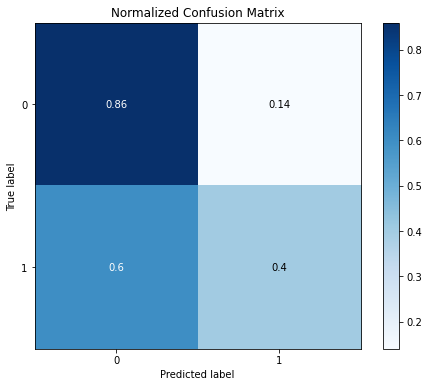

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

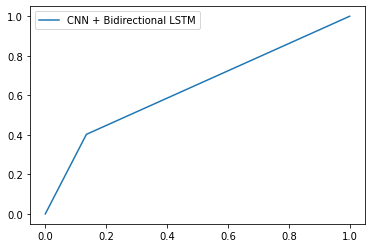

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

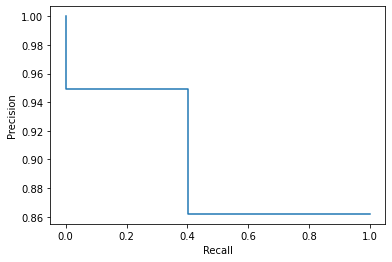

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 4.2 RCNN (Concatenation)

Epoch 1/100
22/22 - 2s - loss: 0.7063 - accuracy: 0.6036 - auc_11: 0.6289 - precision_11: 0.5877 - recall_11: 0.5877 - f1_score: 0.6494 - val_loss: 2.3080 - val_accuracy: 0.5395 - val_auc_11: 0.5920 - val_precision_11: 0.5395 - val_recall_11: 1.0000 - val_f1_score: 0.7009 - 2s/epoch - 88ms/step
Epoch 2/100
22/22 - 0s - loss: 0.6244 - accuracy: 0.6553 - auc_11: 0.7188 - precision_11: 0.6420 - recall_11: 0.6400 - f1_score: 0.6494 - val_loss: 1.8931 - val_accuracy: 0.4474 - val_auc_11: 0.5700 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.7009 - 395ms/epoch - 18ms/step
Epoch 3/100
22/22 - 0s - loss: 0.6097 - accuracy: 0.6746 - auc_11: 0.7357 - precision_11: 0.7043 - recall_11: 0.5569 - f1_score: 0.6494 - val_loss: 2.4773 - val_accuracy: 0.5395 - val_auc_11: 0.6401 - val_precision_11: 0.5395 - val_recall_11: 1.0000 - val_f1_score: 0.7009 - 368ms/epoch - 17ms/step
Epoch 4/100
22/22 - 0s - loss: 0.6187 - accuracy: 0.6820 - auc_11: 0.7289 - precision_11: 0.6647 -

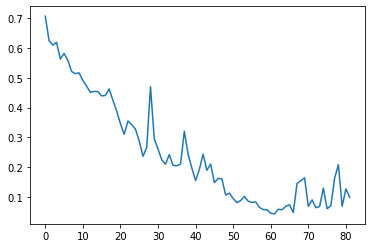

Epoch 1/100
22/22 - 2s - loss: 0.7038 - accuracy: 0.6065 - auc_12: 0.6350 - precision_12: 0.5947 - recall_12: 0.5542 - f1_score: 0.6466 - val_loss: 0.9279 - val_accuracy: 0.6053 - val_auc_12: 0.6392 - val_precision_12: 0.6000 - val_recall_12: 0.9070 - val_f1_score: 0.7227 - 2s/epoch - 84ms/step
Epoch 2/100
22/22 - 0s - loss: 0.6570 - accuracy: 0.6598 - auc_12: 0.7013 - precision_12: 0.6742 - recall_12: 0.5573 - f1_score: 0.6466 - val_loss: 1.5030 - val_accuracy: 0.5658 - val_auc_12: 0.6483 - val_precision_12: 0.5658 - val_recall_12: 1.0000 - val_f1_score: 0.7227 - 352ms/epoch - 16ms/step
Epoch 3/100
22/22 - 0s - loss: 0.5856 - accuracy: 0.7071 - auc_12: 0.7640 - precision_12: 0.7256 - recall_12: 0.6223 - f1_score: 0.6466 - val_loss: 1.5154 - val_accuracy: 0.5921 - val_auc_12: 0.6540 - val_precision_12: 0.5811 - val_recall_12: 1.0000 - val_f1_score: 0.7227 - 304ms/epoch - 14ms/step
Epoch 4/100
22/22 - 0s - loss: 0.5742 - accuracy: 0.7071 - auc_12: 0.7724 - precision_12: 0.7163 - recall_

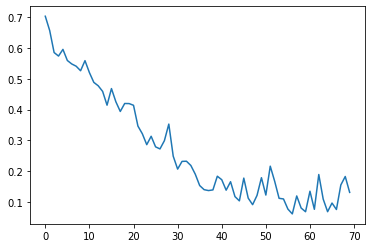

Epoch 1/100
22/22 - 2s - loss: 0.6909 - accuracy: 0.6086 - auc_13: 0.6323 - precision_13: 0.6063 - recall_13: 0.5753 - f1_score: 0.6581 - val_loss: 8.9989 - val_accuracy: 0.4533 - val_auc_13: 0.4853 - val_precision_13: 0.4533 - val_recall_13: 1.0000 - val_f1_score: 0.6239 - 2s/epoch - 104ms/step
Epoch 2/100
22/22 - 0s - loss: 0.6095 - accuracy: 0.6957 - auc_13: 0.7304 - precision_13: 0.7299 - recall_13: 0.6024 - f1_score: 0.6581 - val_loss: 4.5741 - val_accuracy: 0.4533 - val_auc_13: 0.5072 - val_precision_13: 0.4533 - val_recall_13: 1.0000 - val_f1_score: 0.6239 - 338ms/epoch - 15ms/step
Epoch 3/100
22/22 - 0s - loss: 0.5878 - accuracy: 0.6809 - auc_13: 0.7487 - precision_13: 0.6921 - recall_13: 0.6295 - f1_score: 0.6581 - val_loss: 4.5758 - val_accuracy: 0.4533 - val_auc_13: 0.5301 - val_precision_13: 0.4533 - val_recall_13: 1.0000 - val_f1_score: 0.6239 - 377ms/epoch - 17ms/step
Epoch 4/100
22/22 - 0s - loss: 0.5816 - accuracy: 0.7016 - auc_13: 0.7615 - precision_13: 0.7124 - recall

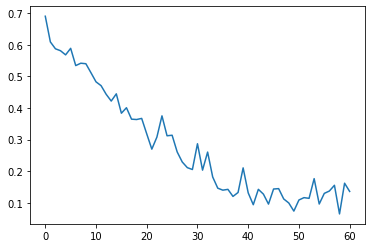

Epoch 1/100
22/22 - 2s - loss: 0.7004 - accuracy: 0.6056 - auc_14: 0.6364 - precision_14: 0.6027 - recall_14: 0.5457 - f1_score: 0.6527 - val_loss: 6.9327 - val_accuracy: 0.5067 - val_auc_14: 0.5000 - val_precision_14: 0.5067 - val_recall_14: 1.0000 - val_f1_score: 0.6726 - 2s/epoch - 89ms/step
Epoch 2/100
22/22 - 0s - loss: 0.6027 - accuracy: 0.6824 - auc_14: 0.7458 - precision_14: 0.6697 - recall_14: 0.6799 - f1_score: 0.6527 - val_loss: 0.7069 - val_accuracy: 0.6267 - val_auc_14: 0.7023 - val_precision_14: 0.6042 - val_recall_14: 0.7632 - val_f1_score: 0.6726 - 343ms/epoch - 16ms/step
Epoch 3/100
22/22 - 0s - loss: 0.6043 - accuracy: 0.6795 - auc_14: 0.7459 - precision_14: 0.6785 - recall_14: 0.6433 - f1_score: 0.6527 - val_loss: 0.9794 - val_accuracy: 0.5733 - val_auc_14: 0.6689 - val_precision_14: 0.5517 - val_recall_14: 0.8421 - val_f1_score: 0.6726 - 304ms/epoch - 14ms/step
Epoch 4/100
22/22 - 0s - loss: 0.5911 - accuracy: 0.6795 - auc_14: 0.7512 - precision_14: 0.6907 - recall_

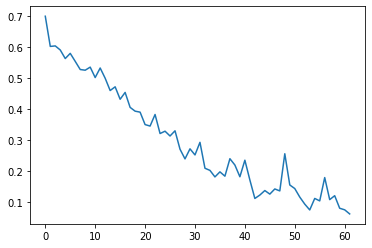

Epoch 1/100
22/22 - 2s - loss: 0.7415 - accuracy: 0.5835 - auc_15: 0.6256 - precision_15: 0.5890 - recall_15: 0.5150 - f1_score: 0.6607 - val_loss: 10.9416 - val_accuracy: 0.4267 - val_auc_15: 0.5000 - val_precision_15: 0.4267 - val_recall_15: 1.0000 - val_f1_score: 0.5981 - 2s/epoch - 88ms/step
Epoch 2/100
22/22 - 0s - loss: 0.6072 - accuracy: 0.6869 - auc_15: 0.7326 - precision_15: 0.6894 - recall_15: 0.6647 - f1_score: 0.6607 - val_loss: 2.0106 - val_accuracy: 0.4267 - val_auc_15: 0.6515 - val_precision_15: 0.4267 - val_recall_15: 1.0000 - val_f1_score: 0.5981 - 338ms/epoch - 15ms/step
Epoch 3/100
22/22 - 0s - loss: 0.5828 - accuracy: 0.7105 - auc_15: 0.7695 - precision_15: 0.7285 - recall_15: 0.6587 - f1_score: 0.6607 - val_loss: 1.8443 - val_accuracy: 0.4400 - val_auc_15: 0.6722 - val_precision_15: 0.4324 - val_recall_15: 1.0000 - val_f1_score: 0.5981 - 335ms/epoch - 15ms/step
Epoch 4/100
22/22 - 0s - loss: 0.5855 - accuracy: 0.7031 - auc_15: 0.7630 - precision_15: 0.6985 - recall

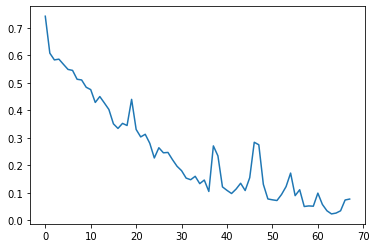

Epoch 1/100
22/22 - 2s - loss: 0.7590 - accuracy: 0.5820 - auc_16: 0.6155 - precision_16: 0.5816 - recall_16: 0.4985 - f1_score: 0.6541 - val_loss: 5.8991 - val_accuracy: 0.4933 - val_auc_16: 0.5000 - val_precision_16: 0.4933 - val_recall_16: 1.0000 - val_f1_score: 0.6607 - 2s/epoch - 86ms/step
Epoch 2/100
22/22 - 0s - loss: 0.5957 - accuracy: 0.6809 - auc_16: 0.7517 - precision_16: 0.7055 - recall_16: 0.5897 - f1_score: 0.6541 - val_loss: 3.7325 - val_accuracy: 0.4933 - val_auc_16: 0.5768 - val_precision_16: 0.4933 - val_recall_16: 1.0000 - val_f1_score: 0.6607 - 370ms/epoch - 17ms/step
Epoch 3/100
22/22 - 0s - loss: 0.6154 - accuracy: 0.6455 - auc_16: 0.7262 - precision_16: 0.6422 - recall_16: 0.6109 - f1_score: 0.6541 - val_loss: 1.9993 - val_accuracy: 0.4933 - val_auc_16: 0.8161 - val_precision_16: 0.4933 - val_recall_16: 1.0000 - val_f1_score: 0.6607 - 339ms/epoch - 15ms/step
Epoch 4/100
22/22 - 0s - loss: 0.5784 - accuracy: 0.7061 - auc_16: 0.7677 - precision_16: 0.7124 - recall_

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_latefusion_model = RCNN(body_features, face_features, n_length, n_outputs, fusion=True)
    history = rcnn_binary_latefusion_model.trainFusioned(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_latefusion_model.save(model_path / 'late_binary_rcnn.h5')

#### Training performance

In [ ]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

#### Validation performance

In [ ]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

#### Predictions and performance on test set

In [ ]:
rcnn_binary_latefusion_model = load_model(model_path / 'late_binary_rcnn.h5')
y_pred = rcnn_binary_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = rcnn_binary_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 4.3 Ensemble

In [ ]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [ ]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [ ]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

## Results

In [ ]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnn_auc, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, rnn_auc, width, label='RCNN')

ax.set_title('Baseline AUC (Binary Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()